# Projeto: Credit Score Model

## Contexto

A continuação o desenvolvimento de um modelo de concessão de crédito (classificação binária). usando as bases confidencial.<br><br>
O projeto completo compreende as seguintes atividades:<br><br>
1. Entendimento da base e análise exploratória dos dados.<br>
2. Pré-processamento das variáveis.<br>
3. Treinamento de um modelo de classificação binária.<br>
4. Análise técnica da performance do modelo, medida sobre a base de Teste.<br>
5. Análise financeira do modelo. Para este ponto, observe a subseção Análise financeira.<br>
6. Escoragem da base Out-of-time, para posterior avaliação da performance pela Prophet/Neurolake.
<br><br>
**Neste Nootebook** concentrarei esforços na **_Análise Exploratoria dos Dados_** que constará de:<br>
1. Análise Univariada (Análise Visual, Técnicas Estatísticas).<br>
2. Análise Bivariada (Análise Visual) .<br>
3. Análise Multivariada (Incluindo Análise Fatorial). <br>
4. Segmentação Experimental (Para ver as relações de algumas variáveis).<br>
5. Conclusões (Levantaremos alguns insights).<br><br>

### Entendimento da Base e Análise Exploratória
<br>

A base contém 150 variáveis, a maioria das quais está mascarada. Utilize a coluna ID como uma key.<br>
A variável alvo é denominada TARGET e possui os seguintes valores:<br><br>

1: Mau Pagador, i.e. atraso > 60 dias em 2 meses.<br>
0: Bom Pagador, i.e. caso contrário.<br>
O score do modelo de classificação deve mapear a classe Bom Pagador.<br><br>
A base de dados está contida na pasta ../datasets/credit_01 e é dividida em 3 partes:<br><br>

Treino: base usada para treinamento contendo dados de janeiro a agosto de 2017;<br>

Teste: base usada para testes contendo dados de janeiro a agosto de 2017;<br><br>

Out-of-time (oot): contém dados obtidos de setembro a novembro de 2017. A escoragem dessa base pode ser uma etapa do desafio, a depender das condições e requisitos combinados.<br>

A base outoftime é considerada uma base "cega" por não possuir a variável "TARGET" (apenas a equipe do Prophet/Neurolake possui acesso a essa variável).<br><br>

Considerando essas premisas, este projeto tem como objetivo:
1. Identificar os fatores associados com risco de crédito na forma de insights de negócio.
2. Oferecer sugestões para minimizar o risco de crédito nas operações.
3. Desenvolver um modelo capaz de prever com precisão a probabilidade de um cliente ser Bom Pagador ou Mau Pagador (inadimplir um empréstimo ou não).<br><br>

A ideia é contrinuir com benefícios tais como melhoría na gestão de riscos, redução de perdas financeiras, aprimoramento da qualidade da carteira, aumento da lucratividade e maior satisfação do cliente.










## Importações

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import inflection
from sklearn.datasets import make_classification
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import missingno as msno  
from imblearn.pipeline import make_pipeline
pd.set_option('display.max_columns', None)
import jupyterthemes as jt 
from jupyterthemes import jtplot  
jtplot.style(theme='monokai')

### Funções Auxiliares

In [2]:
def distribuicao_2(dataframe, variavel, same_scale = True):
    data_wide = dataframe.pivot(columns='TARGET',
                         values=variavel)
    if same_scale == False:
        data_wide[0] = np.log(1 + data_wide[0])
        data_wide[1] = np.log(1 + data_wide[1])
    else:
        pass
        
    data_wide.plot.density(figsize = (15, 7),
                           linewidth = 2)
    if same_scale == False:
        plt.xlabel(variavel+' (em escala logaritimca)')
    else:
        plt.xlabel(variavel)
    lista1 = dataframe.groupby('TARGET')[variavel].describe().round(2).values.tolist()
    lista2 = [list(dataframe.groupby('TARGET')[variavel].describe().round(2).transpose().index)]
    lista3 = [['Não Target', 'Target']] + lista2 + lista1

    #statistics = print(dataframe.groupby('TARGET')[variavel].describe().round(2).transpose().to_string(justify='right'))
    plt.figtext(0.73,0.73, '  '.join(map(str,lista3[0])), {'multialignment':'right'}, fontsize = 12)
    plt.figtext(0.729,0.73, '___________________', {'multialignment':'right'}, fontsize = 12)
    plt.figtext(0.67,0.48, '\n'.join(map(str, lista3[1])), {'multialignment':'left'}, fontsize = 12)
    plt.figtext(0.75,0.48, '\n'.join(map(str,lista3[2])) , {'multialignment':'right'}, fontsize = 12)
    plt.figtext(0.83,0.48, '\n'.join(map(str,lista3[3])) , {'multialignment':'right'}, fontsize = 12)
    plt.show()

### Funções Pipe

In [3]:
def remover_colunas_com_nulos(df, limite_porcentagem_nulos=30):
    """
    Remove colunas com mais de 30% de valores nulos
    """
    porcentagem_nulos = (df.isnull().sum() / len(df)) * 100
    colunas_a_remover = porcentagem_nulos[porcentagem_nulos > limite_porcentagem_nulos].index.tolist()
    df = df.drop(columns=colunas_a_remover)
    return df

def calcular_porcentagem_de_nulos(df):
    """
    Calcula a porcentagem de valores nulos
    """
    perc_nulos = (df.isnull().sum() / len(df)) * 100
    perc_nulos_df = pd.DataFrame({'Coluna': perc_nulos.index, '% de Nulos': perc_nulos.values})
    perc_nulos_df = perc_nulos_df.sort_values(by='% de Nulos', ascending=False)
    return perc_nulos_df

def imputar_valores_nulos(df, colunas, estrategias):    
    for coluna, estrategia in zip(colunas, estrategias):
        if estrategia == 'media':
            imputer = SimpleImputer(strategy='mean')
        elif estrategia == 'moda':
            imputer = SimpleImputer(strategy='most_frequent')
        
        df[coluna] = imputer.fit_transform(df[[coluna]])
        
        
def preencher_nulos_com_outro(df, colunas_a_preencher):
    """
    Preenche os valores nulos com 'Outro'
    """
    for coluna in colunas_a_preencher:
        df[coluna].fillna('Outro', inplace=True)

def imputar_valores_nulos_geral(df):    
    for coluna in df.columns:
        if df[coluna].dtype == 'object':  
            imputer = SimpleImputer(strategy='most_frequent')
        else:
            imputer = SimpleImputer(strategy='mean')
        
        if df[coluna].isnull().any():
            df[coluna] = imputer.fit_transform(df[[coluna]])
            
            
def remove_outliers_iqr(df, threshold=1.5):
    """
    Remove outliers de um DataFrame com base no método IQR (Interquartile Range)

    """
    # Identificar colunas numéricas (excluindo 'ID' e 'IDADE')
    features_numericas = df.select_dtypes(include=['int64', 'float64']).columns.difference(['ID', 'IDADE','TARGET'])

    # Criar uma cópia do DataFrame para preservar o original
    df_no_outliers = df.copy()

    # Remover outliers nas colunas numéricas
    for feature in features_numericas:
        Q1 = df_no_outliers[feature].quantile(0.25)
        Q3 = df_no_outliers[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        df_no_outliers = df_no_outliers[(df_no_outliers[feature] >= lower_bound) & (df_no_outliers[feature] <= upper_bound)]

    return df_no_outliers


### Carregando os Dados

In [4]:
data = pd.read_csv('data_base/train.csv')
#data_teste = pd.read_csv('data_base/test.csv')

## Descrição dos Dados

#### Revisão dos Dados

In [5]:
print(data.shape)
#print(data_teste.shape)

(144469, 151)


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144469 entries, 0 to 144468
Columns: 151 entries, REF_DATE to ID
dtypes: float64(34), int64(3), object(114)
memory usage: 166.4+ MB


In [7]:
data.head(2)

REF_DATE  TARGET VAR2   IDADE VAR4 VAR5       VAR6  \
0  2017-01-25 00:00:00+00:00       1    F  24.471  NaN   SP -23.549841   
1  2017-04-03 00:00:00+00:00       1    F  35.041  NaN   BA -12.924251   

        VAR7 VAR8 VAR9 VAR10  VAR11  VAR12  VAR13  VAR14  VAR15     VAR16  \
0 -46.959865    E    E  ALTA    0.0  0.095    NaN  0.222  0.192  0.083333   
1 -38.487840    E    E  ALTA    0.0  0.005    NaN  0.120    NaN  0.166667   

   VAR17     VAR18  VAR19  VAR20  VAR21  VAR22  VAR23  VAR24  VAR25  VAR26  \
0    NaN  0.983562    2.2    NaN    NaN  0.125    NaN  0.017    0.0    NaN   
1    NaN  1.101370    NaN    NaN    NaN    NaN    NaN  0.017    NaN    NaN   

   VAR27  VAR28  VAR29  VAR30 VAR31 VAR32 VAR33 VAR34 VAR35 VAR36  VAR37  \
0    NaN    NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN   
1    NaN    0.0    NaN  0.063   NaN   NaN   NaN   NaN     S     S  198.0   

  VAR38     VAR39     VAR40     VAR41     VAR42 VAR43  VAR44 VAR45  VAR46  \
0   NaN  0.378548  0.451697  0.438720  0.499008   NaN    NaN   NaN    NaN   
1   NaN  0.476678  0.401271  0.393429  0.508360   NaN    NaN   NaN    NaN   

   VAR47 VAR48 VAR49 VAR50 VAR51 VAR52 VAR53 VAR54 VAR55 VAR56 VAR57 VAR58  \
0    1.0   NaN     S     N     N     N     N     S     N     N     N     N   
1    0.0   NaN     S     N     N     N     N     N     N     N     N     N   

  VAR59 VAR60 VAR61 VAR62 VAR63 VAR64 VAR65  VAR66       VAR67      VAR68  \
0     N     S     S     N     N     N     N  MEDIA        ALTA      MEDIA   
1     N     N     N     N     N     N     N   ALTA  BAIXISSIMA  ALTISSIMA   

  VAR69      VAR70  VAR71 VAR72 VAR73      VAR74      VAR75      VAR76  VAR77  \
0  ALTA      MEDIA  MEDIA  ALTA  ALTA       ALTA      MEDIA       ALTA   ALTA   
1  ALTA  ALTISSIMA   ALTA  ALTA  ALTA  ALTISSIMA  ALTISSIMA  ALTISSIMA  MEDIA   

       VAR78      VAR79  VAR80  VAR81      VAR82 VAR83      VAR84      VAR85  \
0      MEDIA       ALTA  MEDIA  MEDIA       ALTA  ALTA       ALTA       ALTA   
1  ALTISSIMA  ALTISSIMA   ALTA   ALTA  ALTISSIMA  ALTA  ALTISSIMA  ALTISSIMA   

   VAR86  VAR87      VAR88 VAR89       VAR90      VAR91      VAR92  \
0  MEDIA  MEDIA      MEDIA  ALTA  BAIXISSIMA      MEDIA      MEDIA   
1   ALTA   ALTA  ALTISSIMA  ALTA   ALTISSIMA  ALTISSIMA  ALTISSIMA   

        VAR93      VAR94 VAR95  VAR96 VAR97      VAR98  VAR99     VAR100  \
0        ALTA       ALTA  ALTA  MEDIA  ALTA       ALTA  MEDIA  ALTISSIMA   
1  BAIXISSIMA  ALTISSIMA  ALTA   ALTA  ALTA  ALTISSIMA   ALTA  ALTISSIMA   

  VAR101 VAR102 VAR103   VAR104 VAR105 VAR106 VAR107 VAR108   VAR109 VAR110  \
0  MEDIA  LONGE  MEDIO    LONGE  LONGE  LONGE  MEDIO  LONGE  PROXIMO  MEDIO   
1   ALTA  MEDIO  MEDIO  PROXIMO  MEDIO  LONGE  LONGE  LONGE  PROXIMO  MEDIO   

    VAR111 VAR112 VAR113 VAR114   VAR115 VAR116   VAR117         VAR118  \
0    MEDIO  LONGE  MEDIO  MEDIO    LONGE  LONGE    MEDIO          MEDIO   
1  PROXIMO  MEDIO  MEDIO  MEDIO  PROXIMO  MEDIO  PROXIMO  MUITO PROXIMO   

    VAR119       VAR120   VAR121 VAR122 VAR123 VAR124 VAR125 VAR126   VAR127  \
0    LONGE  MUITO LONGE    MEDIO  LONGE  LONGE  LONGE  MEDIO  MEDIO    MEDIO   
1  PROXIMO  MUITO LONGE  PROXIMO  MEDIO  MEDIO  MEDIO  MEDIO  LONGE  PROXIMO   

  VAR128   VAR129 VAR130   VAR131 VAR132 VAR133 VAR134   VAR135   VAR136  \
0  LONGE    LONGE  MEDIO    LONGE  MEDIO  MEDIO  MEDIO    LONGE  PROXIMO   
1  MEDIO  PROXIMO  LONGE  PROXIMO  MEDIO  MEDIO  MEDIO  PROXIMO  PROXIMO   

  VAR137 VAR138 VAR139 VAR140       VAR141 VAR142 VAR143 VAR144  VAR145  \
0  LONGE  MEDIO  LONGE  MEDIO  1399.037809      E    NaN    NaN     NaN   
1  MEDIO  MEDIO  MEDIO  MEDIO  1516.196234      E    NaN    NaN     NaN   

   VAR146  VAR147             VAR148 VAR149      ID  
0     NaN     102  EMAIL INEXISTENTE  2.6.1  280764  
1     NaN     102  EMAIL INEXISTENTE  2.6.1  270129

In [9]:
#teste_copia = data_teste.copy()

### Regra de Negócio

Segundo o entendimento do desafio estipulamos como regras do negócio:<br>
1. Determinar Classe 0 - Bom Pagador como classe Positiva (motivo: "O score do modelo de classificação deve mapear a classe Bom Pagador").<br>
2. Por regras que seguem os Bancos, referente a atuação em empréstimos, é uma regra intrínsica aceitar empréstimos até os 80 anos a Idade, nesse sentido faremos um corte em 90 anos.<br>
3. Variáveis que tenham valores nulos a partir de 30%, serán removidas da análise.


### Determinar TARGET = 0 como Classe Positiva

In [11]:
data['TARGET'] = data['TARGET'].apply(lambda x: 0 if x == 1 else 1)
#data_teste['TARGET'] = data_teste['TARGET'].apply(lambda x: 0 if x == 1 else 1)

### Variável: Idade

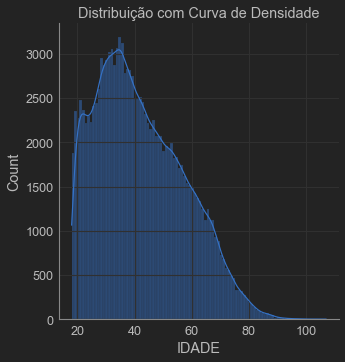

In [12]:
sns.displot(data['IDADE'], kde=True) # "kde=True" adiciona a curva de densidade suavizada
plt.title("Distribuição com Curva de Densidade")
plt.show()

> [!IMPORTANT]
> Por regra de negócio que seguem os bancos, a ideade terá um corte em 90.

In [13]:
data = data.query('IDADE< 91')

In [16]:
print(data.shape)

(127840, 151)


Podemos observar uma diminuição de 11% dos registros da base de treino.

### Dimensão dos Dados

In [17]:
print(data.TARGET.value_counts())
print("\nTargets no Treino representam {:.2f}% do dataset.\n".format((data[data.TARGET == 1].shape[0] / data.shape[0]) * 100))

1    102761
0     25079
Name: TARGET, dtype: int64

Targets no Treino representam 80.38% do dataset.



### Tipo dos Dados

In [18]:
data['REF_DATE'] = pd.to_datetime(data['REF_DATE'])
#data_teste['REF_DATE'] = pd.to_datetime(data_teste['REF_DATE'])
data.dtypes

REF_DATE    datetime64[ns, UTC]
TARGET                    int64
VAR2                     object
IDADE                   float64
VAR4                     object
                   ...         
VAR146                  float64
VAR147                    int64
VAR148                   object
VAR149                   object
ID                        int64
Length: 151, dtype: object

### Dados Ausentes

In [19]:
df = data.copy()
#dftes = data_teste.copy()

#### % Nulos

In [20]:
df_info = calcular_porcentagem_de_nulos(df)
df_info

Coluna  % de Nulos
146  VAR146   99.852941
4      VAR4   99.801314
46    VAR46   99.723874
45    VAR45   99.723874
44    VAR44   99.647997
..      ...         ...
1    TARGET    0.000000
47    VAR47    0.000000
39    VAR39    0.000000
3     IDADE    0.000000
150      ID    0.000000

[151 rows x 2 columns]

### Aplicando 2da Regra de Negócio 

In [22]:
# Removemos colunas com presença de nulas maior a 30%
df = remover_colunas_com_nulos(df)
#dftes = remover_colunas_com_nulos(dftes)

In [23]:
print(df.shape)

(127840, 115)


In [24]:
df_info1 = calcular_porcentagem_de_nulos(df)
df_info1

Coluna  % de Nulos
10    VAR18   15.745463
9     VAR14   15.745463
11    VAR24   13.897841
4      VAR5    2.000939
5      VAR6    2.000939
..      ...         ...
1    TARGET    0.000000
16    VAR47    0.000000
12    VAR39    0.000000
3     IDADE    0.000000
114      ID    0.000000

[115 rows x 2 columns]

### Remoção de Outliers

Nesta fase não faremos essa remoção porque queremos ver o comportamento de cada uma das variáveis.

### Preenchendo valores vazios

In [25]:
df_info3 = calcular_porcentagem_de_nulos(df)
df_info3

Coluna  % de Nulos
10    VAR18   15.745463
9     VAR14   15.745463
11    VAR24   13.897841
4      VAR5    2.000939
5      VAR6    2.000939
..      ...         ...
1    TARGET    0.000000
16    VAR47    0.000000
12    VAR39    0.000000
3     IDADE    0.000000
114      ID    0.000000

[115 rows x 2 columns]

### Imputações com Media e Moda

Se os dados são numéricos imputaremos com a Média.<br>
Se os dados são categóricos imputaremos com a Moda.

In [27]:
colunas_a_preencher = ['VAR2', 'VAR49', 'VAR50', 'VAR51', 'VAR52', 'VAR53', 'VAR54', 'VAR55', 'VAR56', 'VAR57', 'VAR58', 'VAR59', 'VAR60', 'VAR61', 'VAR62', 'VAR63', 'VAR64', 'VAR65', 'VAR5']
preencher_nulos_com_outro(df, colunas_a_preencher)
#preencher_nulos_com_outro(dftes, colunas_a_preencher)

imputar_valores_nulos(df, colunas=['IDADE','VAR40','VAR9','VAR10','VAR14','VAR6','VAR7', 'VAR14', 'VAR18', 'VAR24', 'VAR39', 'VAR140', 'VAR84', 'VAR85', 'VAR87', 'VAR142', 'VAR114', 'VAR109', 'VAR115', 'VAR134', 'VAR135', 'VAR82', 'VAR86', 'VAR88', 'VAR42'], 
                      estrategias=['media','moda','moda','moda','media','moda','moda', 'media', 'media', 'media', 'media', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda','media'])
#imputar_valores_nulos(dftes, colunas=['IDADE','VAR40','VAR9','VAR10','VAR14','VAR6','VAR7', 'VAR14', 'VAR18', 'VAR24', 'VAR39', 'VAR140', 'VAR84', 'VAR85', 'VAR87', 'VAR142', 'VAR114', 'VAR109', 'VAR115', 'VAR134', 'VAR135', 'VAR82', 'VAR86', 'VAR88', 'VAR42'], 
#                      estrategias=['media','moda','moda','moda','media','moda','moda', 'media', 'media', 'media', 'media', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda','media'])

imputar_valores_nulos_geral(df)
#imputar_valores_nulos_geral(dftes)

df_info2 = calcular_porcentagem_de_nulos(df)
#df_info4 = calcular_porcentagem_de_nulos(dftes)

In [28]:
## Verificação final 
df_info2

Coluna  % de Nulos
0    REF_DATE         0.0
86     VAR118         0.0
84     VAR116         0.0
83     VAR115         0.0
82     VAR114         0.0
..        ...         ...
34      VAR66         0.0
33      VAR65         0.0
32      VAR64         0.0
31      VAR63         0.0
114        ID         0.0

[115 rows x 2 columns]

Agora obtemos o nosso dataset livre de valores nulos.

### Matríz de dados faltante

A Matríz verifica visualmente que resolvimos a situação de dados faltantes ou vazíos.

<AxesSubplot:>

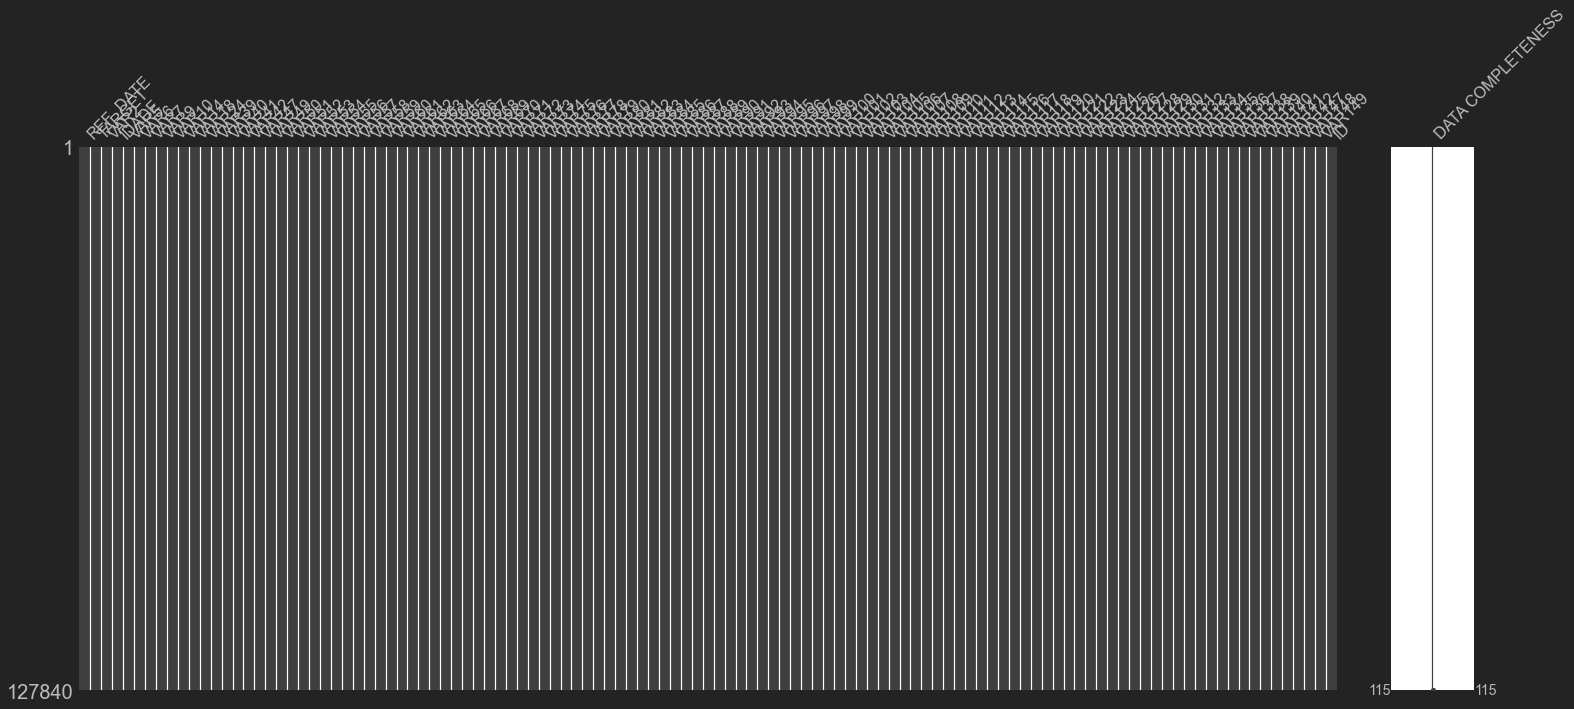

In [29]:
msno.matrix(df, labels=True)  

### Remoção de Features Constantes

In [30]:
# Identificar as features constantes
colunas_constantes = [coluna for coluna in df.columns if df[coluna].nunique() == 1]
df = df.drop(columns=colunas_constantes)

In [31]:
# Identificar as features constantes
#colunas_constantes = [coluna for coluna in dftes.columns if dftes[coluna].nunique() == 1]

#dftes = dftes.drop(columns=colunas_constantes)

## Tratamento dos Dados

In [33]:
df['DIA'] = df['REF_DATE'].dt.day
df['SEM'] = df['REF_DATE'].dt.week
#dftes['DIA'] = dftes['REF_DATE'].dt.day
#dftes['SEM'] = dftes['REF_DATE'].dt.week

### Transformação por Natureza

Fazendo uma copia para reagir ante qualquer eventualidade

In [34]:
# Dia
df['DIA_SIN'] = df['DIA'].apply(lambda x: np.sin(x *(2. * np.pi/30)))
df['DIA_COS'] = df['DIA'].apply(lambda x: np.cos(x *(2. * np.pi/30)))
# Semana
df['SEM_SIN'] = df['SEM'].apply(lambda x: np.sin(x *(2. * np.pi/7)))
df['SEM_COS'] = df['SEM'].apply(lambda x: np.cos(x *(2. * np.pi/7)))

# Dia
#dftes['DIA_SIN'] = dftes['DIA'].apply(lambda x: np.sin(x *(2. * np.pi/30)))
#dftes['DIA_COS'] = dftes['DIA'].apply(lambda x: np.cos(x *(2. * np.pi/30)))
# Semana
#dftes['SEM_SIN'] = dftes['SEM'].apply(lambda x: np.sin(x *(2. * np.pi/7)))
#dftes['SEM_COS'] = dftes['SEM'].apply(lambda x: np.cos(x *(2. * np.pi/7)))

In [35]:
#copia_df_testes_1 = dftes.copy()

## E.D.A.

### Análise Univariada

#### Variável Target

VIsualizando a distribuição das nossas classes alvos.

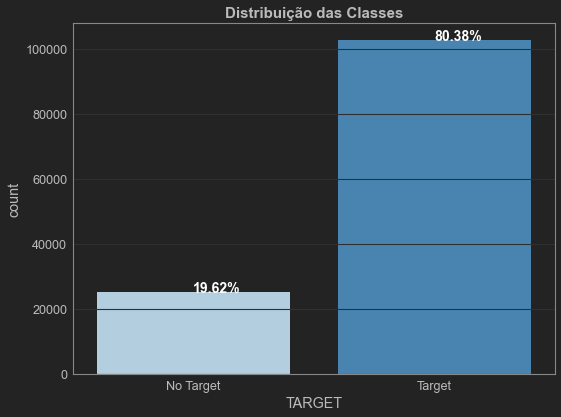

In [36]:
#sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='TARGET', palette='Blues')
ax.set_title('Distribuição das Classes', fontsize=15, loc='center', weight='bold')
ax.set_xticklabels(['No Target', 'Target'], rotation=0)
total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height/total:.2%}', (p.get_x() + p.get_width() / 2., height - 50),
                fontsize=14, color='white', weight='bold')
plt.tight_layout()
plt.show()

Já esperávamos que as classes foram desbalanceadas.<br><br>
A continuação analisaremos variaveis númericas e categóricas por separado

Lembrando que agora a classe TARGET corresponde ao "BOM PAGADOR"<br><br> Trataremos este ponto mediante a aplicação de alguma estrategia como por exemplo:
1. Smote: Ela tenta equilibrar as classes, criando artificialmente exemplos adicionais da classe minoritária, sintetizando novos pontos de dados com base nos exemplos existentes.<br><br>
2. SmoteKNN: Ela é uma extensão do SMOTE (Synthetic Minority Over-sampling Technique) que combina a geração sintética de exemplos da classe minoritária com a técnica KNN (K-Nearest Neighbors). <br><br>
3. Foco na curva ROC-AUC. A curva ROC AUC e seu valor AUC associado ajudam avaliar o quão bem um modelo de credit score diferencia entre clientes que irão inadimplir e aquele que não irão.

#### Variáveis numéricas

In [37]:
num_attributes = df.select_dtypes(include=['int64','float64','int32'])
num_attributes.shape

(127840, 21)

##### Descrição Estatística

In [38]:
num_attributes.describe()

TARGET          IDADE           VAR6           VAR7  \
count  127840.000000  127840.000000  127840.000000  127840.000000   
mean        0.803825      42.097349     -14.935325     -46.076253   
std         0.397104      15.170443       9.107667       7.462730   
min         0.000000      18.014000     -33.521563     -72.900276   
25%         1.000000      30.003000     -23.093116     -50.513559   
50%         1.000000      39.819000     -14.865949     -46.702500   
75%         1.000000      53.005000      -6.776932     -39.252710   
max         1.000000      90.948000       4.478585     -32.429516   

              VAR14          VAR18          VAR24          VAR39  \
count  127840.00000  127840.000000  127840.000000  127840.000000   
mean        0.15014       0.986690       0.081367       0.474249   
std         0.11397       0.457155       0.130300       0.136738   
min         0.00000       0.002740       0.000000       0.049309   
25%         0.11000       0.503899       0.000000       0.381631   
50%         0.13900       0.986690       0.052000       0.470947   
75%         0.15100       1.353425       0.081367       0.566941   
max         1.00000       2.471023       1.000000       0.970921   

               VAR40          VAR41          VAR42          VAR47  \
count  127840.000000  127840.000000  127840.000000  127840.000000   
mean        0.530799       0.629786       0.504792       0.289843   
std         0.114918       0.219512       0.069675       0.420951   
min         0.208688       0.000000       0.006658       0.000000   
25%         0.449547       0.442536       0.463595       0.001000   
50%         0.507846       0.545414       0.496036       0.009000   
75%         0.580595       0.889606       0.522811       0.737000   
max         0.920685       1.000000       0.910865       1.000000   

              VAR141         VAR147             ID            DIA  \
count  127840.000000  127840.000000  127840.000000  127840.000000   
mean     1906.748963     101.821058  165351.435067      15.653317   
std       937.384461       0.570848   95568.084838       8.934981   
min         0.000000     100.000000       1.000000       1.000000   
25%      1548.109828     102.000000   82445.000000       8.000000   
50%      1688.051189     102.000000  165383.500000      16.000000   
75%      1891.584279     102.000000  248186.250000      24.000000   
max     46685.420000     102.000000  330581.000000      31.000000   

                 SEM       DIA_SIN        DIA_COS       SEM_SIN        SEM_COS  
count  127840.000000  1.278400e+05  127840.000000  1.278400e+05  127840.000000  
mean       18.895189  2.052626e-02       0.039349 -2.684116e-02       0.004571  
std         9.855848  7.084333e-01       0.704387  7.077641e-01       0.705930  
min         1.000000 -9.945219e-01      -1.000000 -9.749279e-01      -0.900969  
25%        11.000000 -7.431448e-01      -0.669131 -7.818315e-01      -0.900969  
50%        19.000000  1.224647e-16       0.104528 -7.347881e-16      -0.222521  
75%        28.000000  7.431448e-01       0.809017  7.818315e-01       0.623490  
max        35.000000  9.945219e-01       1.000000  9.749279e-01       1.000000

Alguns pontos interessantes:
1. A media da idade é aproximadamente 42 anos.
2. O desvio da IDADE é aproximadamente 15 anos .
3. A variável VAR141 parece ter uma característica de salário ou em todo caso de valor emprestado. Muita atenção nessa variável porque segundo a sua relação com a TARGET podería ter muita incidencia na discriminação das classes. 

Prestaremos atenção nas avaliações independentes das variáveis.

##### Visão Geral 

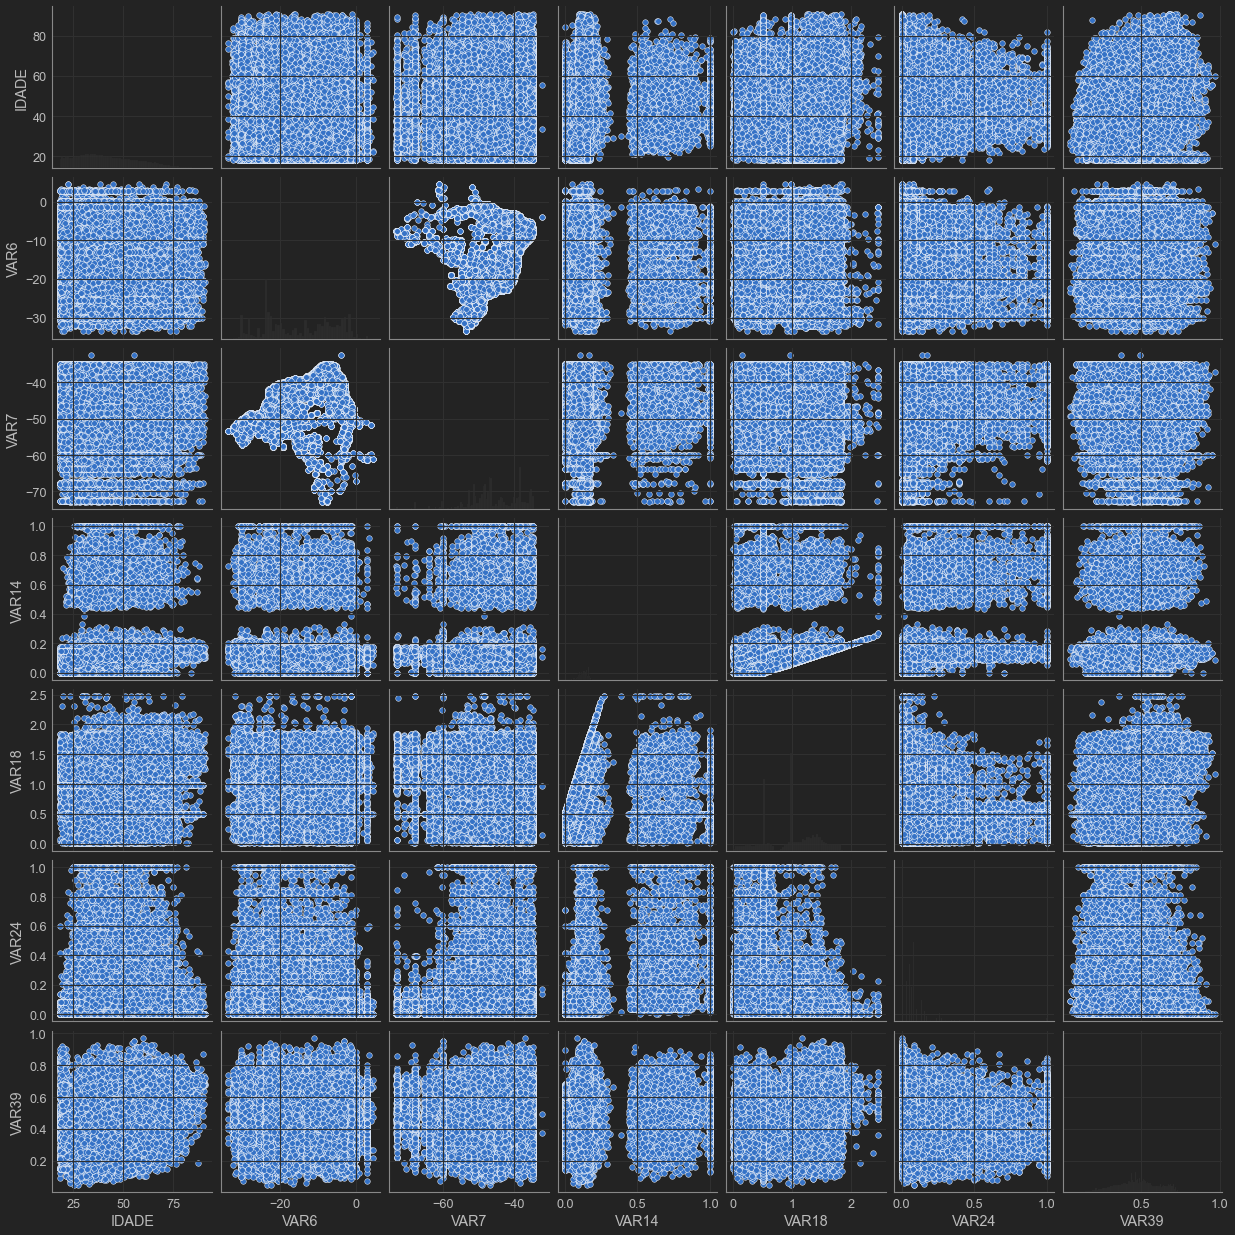

In [39]:
colunas = ['IDADE', 'VAR6', 'VAR7', 'VAR14', 'VAR18', 'VAR24', 'VAR39']
sns.pairplot(num_attributes[colunas])
plt.show()

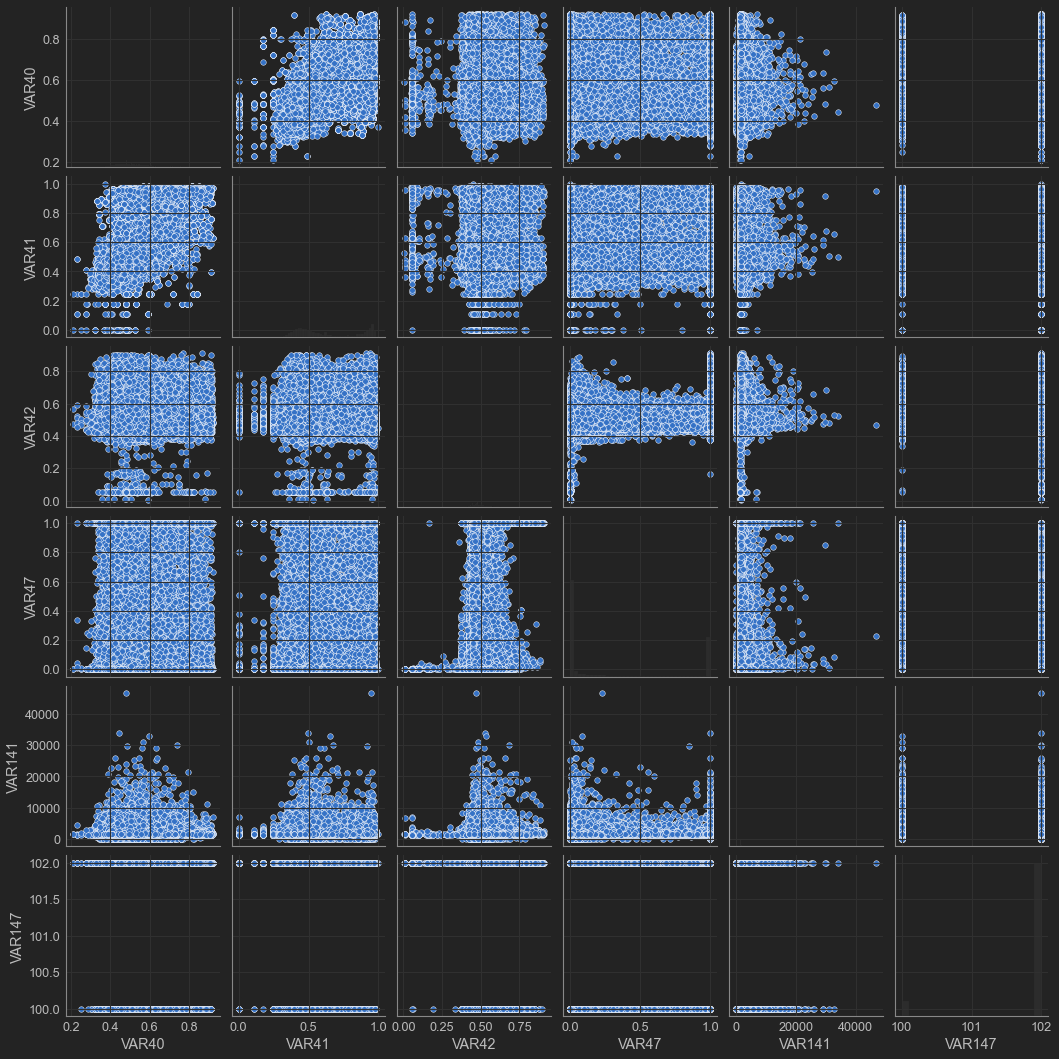

In [40]:
colunas = ['VAR40', 'VAR41', 'VAR42', 'VAR47', 'VAR141', 'VAR147']
sns.pairplot(num_attributes[colunas])
plt.show()

Desde já conseguimos perceber que algumas das nossas variáveis seguem uma distribuição normal (VAR7, IDADE, VAR39), o que é bom para a premissa dos modelos de machine learning.<br><br> Já outras, ficam longe de parecer seguir uma distribuição normal. Mas para ter certeza de alguma delas aplicaremos um teste **Shapiro**.<br> 

A continuação observaremos independentemente cada uma das variáveis numéricas.

##### IDADE

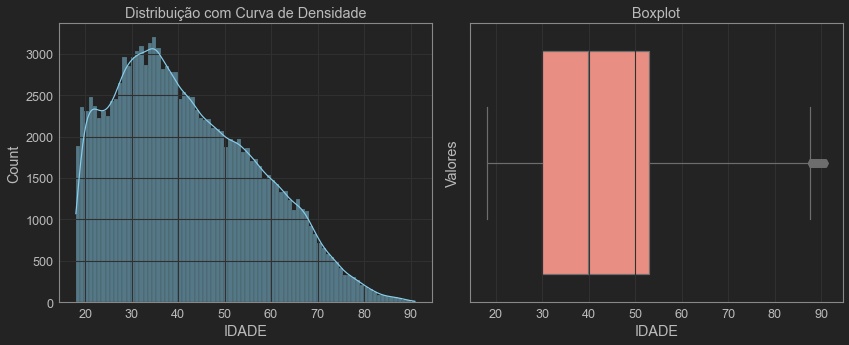

In [101]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cor_histplot = 'skyblue'
sns.histplot(df['IDADE'], kde=True, color=cor_histplot, ax=axes[0])
axes[0].set_title("Distribuição com Curva de Densidade")
cor_boxplot = 'salmon'
sns.boxplot(x=df['IDADE'], color=cor_boxplot, ax=axes[1])
axes[1].set_ylabel('Valores')
axes[1].set_title("Boxplot")
plt.tight_layout()
plt.show()

In [103]:
from scipy import stats
alvo = df['IDADE']
stat, p = stats.shapiro(alvo)
alpha = 0.05
if p > alpha:
    print(f'A coluna {alvo.name} parece seguir uma distribuição normal (p = {p})')
else:
    print(f'A coluna {alvo.name} não segue uma distribuição normal (p = {p})')


A coluna IDADE não segue uma distribuição normal (p = 0.0)


##### VAR6

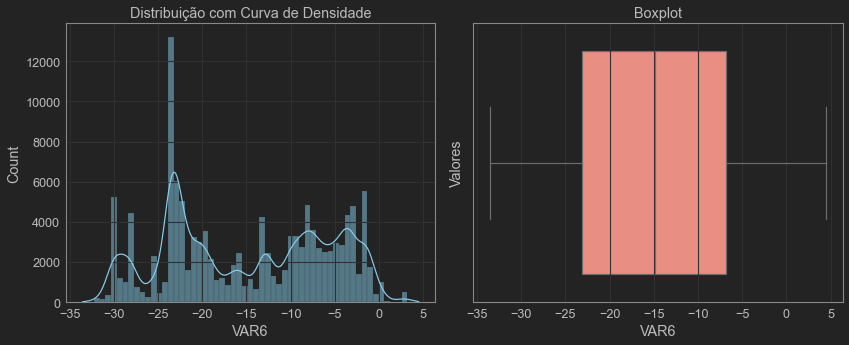

In [104]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cor_histplot = 'skyblue'
sns.histplot(df['VAR6'], kde=True, color=cor_histplot, ax=axes[0])
axes[0].set_title("Distribuição com Curva de Densidade")
cor_boxplot = 'salmon'
sns.boxplot(x=df['VAR6'], color=cor_boxplot, ax=axes[1])
axes[1].set_ylabel('Valores')
axes[1].set_title("Boxplot")
plt.tight_layout()
plt.show()

In [105]:
from scipy import stats
alvo = df['VAR6']
stat, p = stats.shapiro(alvo)
alpha = 0.05
if p > alpha:
    print(f'A coluna {alvo.name} parece seguir uma distribuição normal (p = {p})')
else:
    print(f'A coluna {alvo.name} não segue uma distribuição normal (p = {p})')

A coluna VAR6 não segue uma distribuição normal (p = 0.0)


##### VAR7

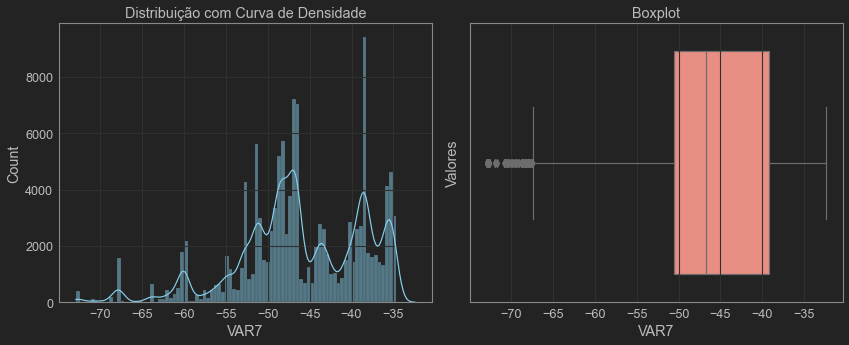

In [106]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cor_histplot = 'skyblue'
sns.histplot(df['VAR7'], kde=True, color=cor_histplot, ax=axes[0])
axes[0].set_title("Distribuição com Curva de Densidade")
cor_boxplot = 'salmon'
sns.boxplot(x=df['VAR7'], color=cor_boxplot, ax=axes[1])
axes[1].set_ylabel('Valores')
axes[1].set_title("Boxplot")
plt.tight_layout()
plt.show()

In [107]:
from scipy import stats
alvo = df['VAR7']
stat, p = stats.shapiro(alvo)
alpha = 0.05
if p > alpha:
    print(f'A coluna {alvo.name} parece seguir uma distribuição normal (p = {p})')
else:
    print(f'A coluna {alvo.name} não segue uma distribuição normal (p = {p})')

A coluna VAR7 não segue uma distribuição normal (p = 0.0)


##### VAR14

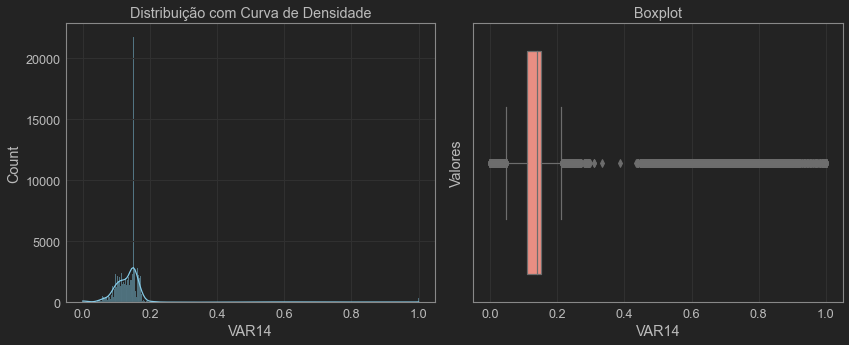

In [108]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cor_histplot = 'skyblue'
sns.histplot(df['VAR14'], kde=True, color=cor_histplot, ax=axes[0])
axes[0].set_title("Distribuição com Curva de Densidade")
cor_boxplot = 'salmon'
sns.boxplot(x=df['VAR14'], color=cor_boxplot, ax=axes[1])
axes[1].set_ylabel('Valores')
axes[1].set_title("Boxplot")
plt.tight_layout()
plt.show()

Nota: Devemos Trabalhar esses Outliers. Estratégia de IQR ou Z-score, analisaremos melhor na fase de tratamento de dados!

In [109]:
from scipy import stats
alvo = df['VAR14']
stat, p = stats.shapiro(alvo)
alpha = 0.05
if p > alpha:
    print(f'A coluna {alvo.name} parece seguir uma distribuição normal (p = {p})')
else:
    print(f'A coluna {alvo.name} não segue uma distribuição normal (p = {p})')


A coluna VAR14 não segue uma distribuição normal (p = 0.0)


##### VAR18

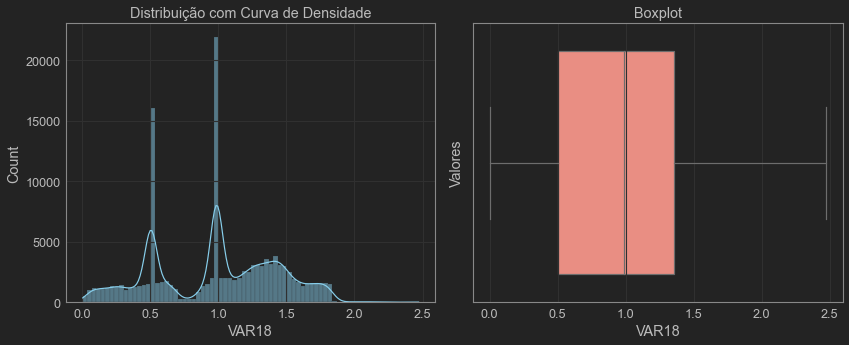

In [110]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cor_histplot = 'skyblue'
sns.histplot(df['VAR18'], kde=True, color=cor_histplot, ax=axes[0])
axes[0].set_title("Distribuição com Curva de Densidade")
cor_boxplot = 'salmon'
sns.boxplot(x=df['VAR18'], color=cor_boxplot, ax=axes[1])
axes[1].set_ylabel('Valores')
axes[1].set_title("Boxplot")
plt.tight_layout()
plt.show()

In [111]:
from scipy import stats
alvo = df['VAR18']
stat, p = stats.shapiro(alvo)
alpha = 0.05
if p > alpha:
    print(f'A coluna {alvo.name} parece seguir uma distribuição normal (p = {p})')
else:
    print(f'A coluna {alvo.name} não segue uma distribuição normal (p = {p})')

A coluna VAR18 não segue uma distribuição normal (p = 0.0)


##### VAR24

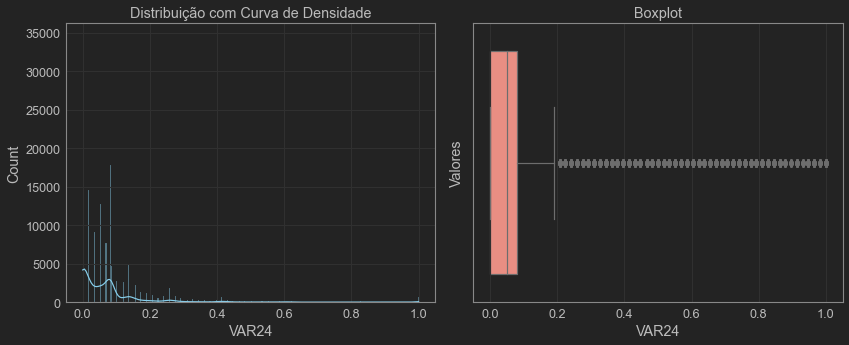

In [112]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cor_histplot = 'skyblue'
sns.histplot(df['VAR24'], kde=True, color=cor_histplot, ax=axes[0])
axes[0].set_title("Distribuição com Curva de Densidade")
cor_boxplot = 'salmon'
sns.boxplot(x=df['VAR24'], color=cor_boxplot, ax=axes[1])
axes[1].set_ylabel('Valores')
axes[1].set_title("Boxplot")
plt.tight_layout()
plt.show()

Nota: Devemos trabalhar nos outliers, ou focar num tipo de Normalização que cuide deles (RobustScaler)

In [113]:
from scipy import stats
alvo = df['VAR24']
stat, p = stats.shapiro(alvo)
alpha = 0.05
if p > alpha:
    print(f'A coluna {alvo.name} parece seguir uma distribuição normal (p = {p})')
else:
    print(f'A coluna {alvo.name} não segue uma distribuição normal (p = {p})')

A coluna VAR24 não segue uma distribuição normal (p = 0.0)


##### VAR39

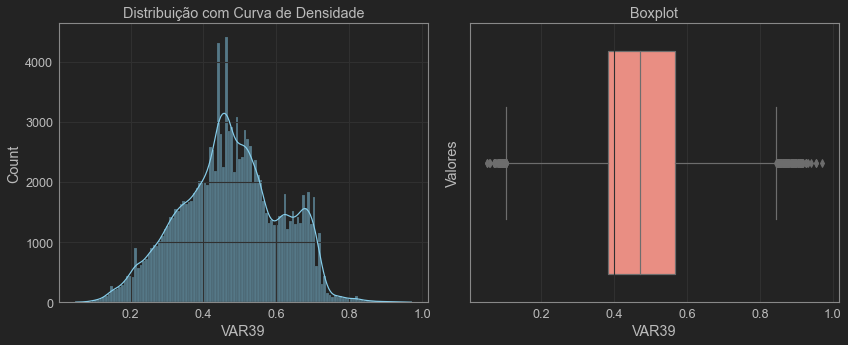

In [114]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cor_histplot = 'skyblue'
sns.histplot(df['VAR39'], kde=True, color=cor_histplot, ax=axes[0])
axes[0].set_title("Distribuição com Curva de Densidade")
cor_boxplot = 'salmon'
sns.boxplot(x=df['VAR39'], color=cor_boxplot, ax=axes[1])
axes[1].set_ylabel('Valores')
axes[1].set_title("Boxplot")
plt.tight_layout()
plt.show()

In [115]:
from scipy import stats
alvo = df['VAR39']
stat, p = stats.shapiro(alvo)
alpha = 0.05
if p > alpha:
    print(f'A coluna {alvo.name} parece seguir uma distribuição normal (p = {p})')
else:
    print(f'A coluna {alvo.name} não segue uma distribuição normal (p = {p})')

A coluna VAR39 não segue uma distribuição normal (p = 0.0)


##### VAR40

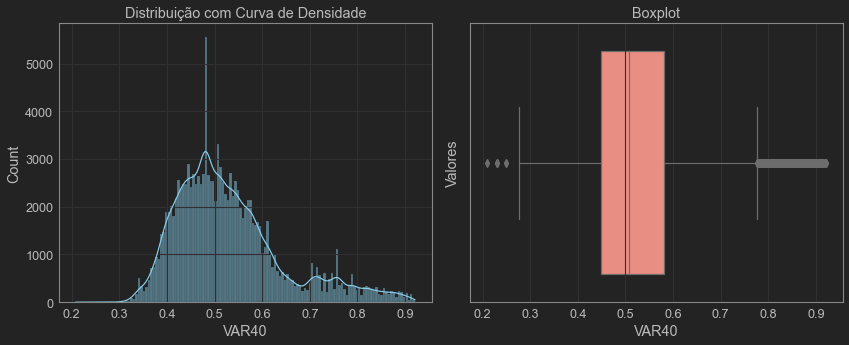

In [116]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cor_histplot = 'skyblue'
sns.histplot(df['VAR40'], kde=True, color=cor_histplot, ax=axes[0])
axes[0].set_title("Distribuição com Curva de Densidade")
cor_boxplot = 'salmon'
sns.boxplot(x=df['VAR40'], color=cor_boxplot, ax=axes[1])
axes[1].set_ylabel('Valores')
axes[1].set_title("Boxplot")
plt.tight_layout()
plt.show()

In [117]:
from scipy import stats
alvo = df['VAR40']
stat, p = stats.shapiro(alvo)
alpha = 0.05
if p > alpha:
    print(f'A coluna {alvo.name} parece seguir uma distribuição normal (p = {p})')
else:
    print(f'A coluna {alvo.name} não segue uma distribuição normal (p = {p})')

A coluna VAR40 não segue uma distribuição normal (p = 0.0)


##### VAR41

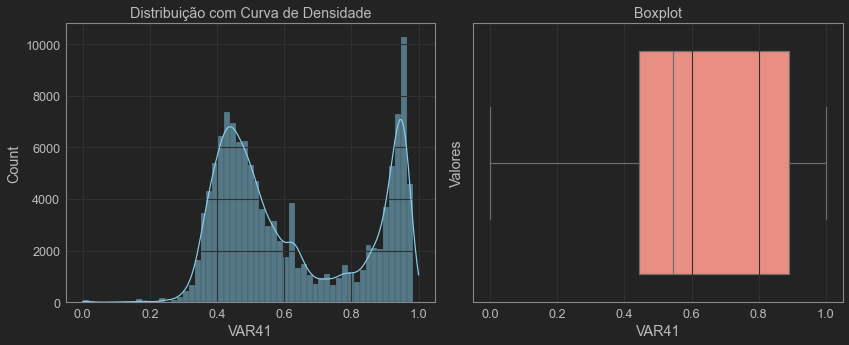

In [118]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cor_histplot = 'skyblue'
sns.histplot(df['VAR41'], kde=True, color=cor_histplot, ax=axes[0])
axes[0].set_title("Distribuição com Curva de Densidade")
cor_boxplot = 'salmon'
sns.boxplot(x=df['VAR41'], color=cor_boxplot, ax=axes[1])
axes[1].set_ylabel('Valores')
axes[1].set_title("Boxplot")
plt.tight_layout()
plt.show()

In [119]:
from scipy import stats
alvo = df['VAR41']
stat, p = stats.shapiro(alvo)
alpha = 0.05
if p > alpha:
    print(f'A coluna {alvo.name} parece seguir uma distribuição normal (p = {p})')
else:
    print(f'A coluna {alvo.name} não segue uma distribuição normal (p = {p})')

A coluna VAR41 não segue uma distribuição normal (p = 0.0)


##### VAR42

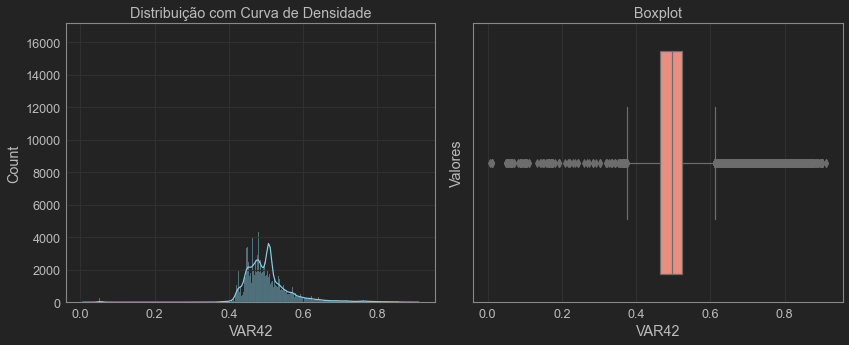

In [120]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cor_histplot = 'skyblue'
sns.histplot(df['VAR42'], kde=True, color=cor_histplot, ax=axes[0])
axes[0].set_title("Distribuição com Curva de Densidade")
cor_boxplot = 'salmon'
sns.boxplot(x=df['VAR42'], color=cor_boxplot, ax=axes[1])
axes[1].set_ylabel('Valores')
axes[1].set_title("Boxplot")
plt.tight_layout()
plt.show()

In [121]:
from scipy import stats
alvo = df['VAR42']
stat, p = stats.shapiro(alvo)
alpha = 0.05
if p > alpha:
    print(f'A coluna {alvo.name} parece seguir uma distribuição normal (p = {p})')
else:
    print(f'A coluna {alvo.name} não segue uma distribuição normal (p = {p})')

A coluna VAR42 não segue uma distribuição normal (p = 0.0)


##### VAR47 

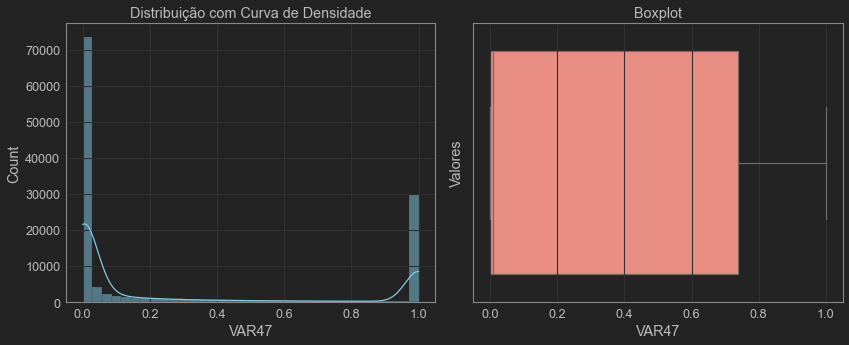

In [122]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cor_histplot = 'skyblue'
sns.histplot(df['VAR47'], kde=True, color=cor_histplot, ax=axes[0])
axes[0].set_title("Distribuição com Curva de Densidade")
cor_boxplot = 'salmon'
sns.boxplot(x=df['VAR47'], color=cor_boxplot, ax=axes[1])
axes[1].set_ylabel('Valores')
axes[1].set_title("Boxplot")
plt.tight_layout()
plt.show()

In [123]:
from scipy import stats
alvo = df['VAR47']
stat, p = stats.shapiro(alvo)
alpha = 0.05
if p > alpha:
    print(f'A coluna {alvo.name} parece seguir uma distribuição normal (p = {p})')
else:
    print(f'A coluna {alvo.name} não segue uma distribuição normal (p = {p})')

A coluna VAR47 não segue uma distribuição normal (p = 0.0)


##### VAR141

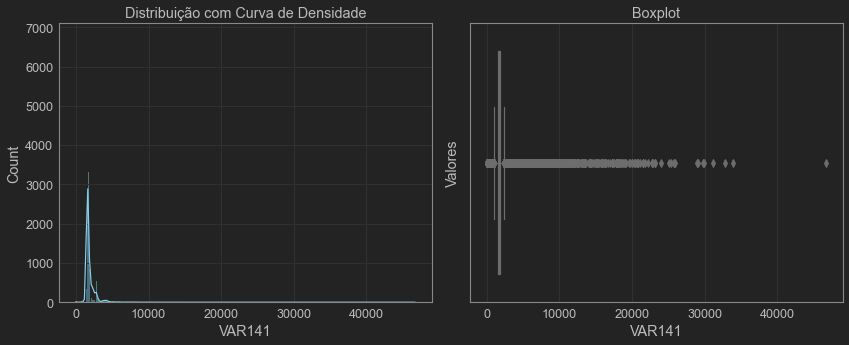

In [124]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cor_histplot = 'skyblue'
sns.histplot(df['VAR141'], kde=True, color=cor_histplot, ax=axes[0])
axes[0].set_title("Distribuição com Curva de Densidade")
cor_boxplot = 'salmon'
sns.boxplot(x=df['VAR141'], color=cor_boxplot, ax=axes[1])
axes[1].set_ylabel('Valores')
axes[1].set_title("Boxplot")
plt.tight_layout()
plt.show()

In [125]:
from scipy import stats
alvo = df['VAR141']
stat, p = stats.shapiro(alvo)
alpha = 0.05
if p > alpha:
    print(f'A coluna {alvo.name} parece seguir uma distribuição normal (p = {p})')
else:
    print(f'A coluna {alvo.name} não segue uma distribuição normal (p = {p})')

A coluna VAR141 não segue uma distribuição normal (p = 0.0)


Nota: Coluna precisa ser analisada, demasiados outliers. Mas continuo tendo o filling que essa coluna pode ser uma caraterística monetaria.

##### VAR147

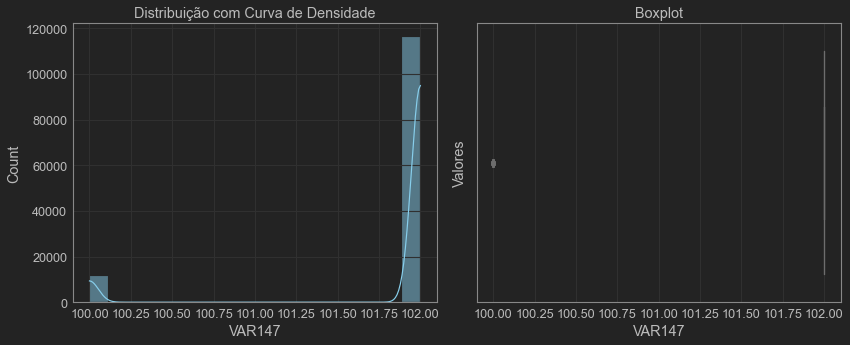

In [126]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cor_histplot = 'skyblue'
sns.histplot(df['VAR147'], kde=True, color=cor_histplot, ax=axes[0])
axes[0].set_title("Distribuição com Curva de Densidade")
cor_boxplot = 'salmon'
sns.boxplot(x=df['VAR147'], color=cor_boxplot, ax=axes[1])
axes[1].set_ylabel('Valores')
axes[1].set_title("Boxplot")
plt.tight_layout()
plt.show()

In [127]:
from scipy import stats
alvo = df['VAR147']
stat, p = stats.shapiro(alvo)
alpha = 0.05
if p > alpha:
    print(f'A coluna {alvo.name} parece seguir uma distribuição normal (p = {p})')
else:
    print(f'A coluna {alvo.name} não segue uma distribuição normal (p = {p})')

A coluna VAR147 não segue uma distribuição normal (p = 0.0)


#### Variáveis Categóricas

##### Visão Geral

In [128]:
cat_attributes = df.select_dtypes(exclude=['int64','float64','datetime64[ns]','int32'])

In [73]:
for feature in cat_attributes:
    print(feature)
    print('-'*40)
    print(f'There are {cat_attributes[feature].nunique()} unique values. They are: ')
    print(cat_attributes[feature].value_counts(normalize=True))
    print()

REF_DATE
----------------------------------------
There are 242 unique values. They are: 
2017-03-31 00:00:00+00:00    0.009598
2017-08-04 00:00:00+00:00    0.006790
2017-08-01 00:00:00+00:00    0.006492
2017-07-07 00:00:00+00:00    0.006360
2017-03-25 00:00:00+00:00    0.006320
                               ...   
2017-01-08 00:00:00+00:00    0.000289
2017-02-12 00:00:00+00:00    0.000289
2017-02-26 00:00:00+00:00    0.000274
2017-01-22 00:00:00+00:00    0.000242
2017-01-15 00:00:00+00:00    0.000219
Name: REF_DATE, Length: 242, dtype: float64

VAR2
----------------------------------------
There are 3 unique values. They are: 
F        0.561546
M        0.429928
Outro    0.008526
Name: VAR2, dtype: float64

VAR5
----------------------------------------
There are 28 unique values. They are: 
SP       0.163830
BA       0.083730
PA       0.081688
RS       0.073107
CE       0.067006
MG       0.066568
PE       0.057854
RJ       0.039941
AM       0.033784
PR       0.032134
RN       0.03145

BAIXISSIMA    0.301001
MEDIA         0.258057
ALTA          0.233894
ALTISSIMA     0.207048
Name: VAR86, dtype: float64

VAR87
----------------------------------------
There are 5 unique values. They are: 
MEDIA         0.286616
ALTA          0.236522
ALTISSIMA     0.219165
BAIXISSIMA    0.198983
BAIXA         0.058714
Name: VAR87, dtype: float64

VAR88
----------------------------------------
There are 5 unique values. They are: 
ALTISSIMA     0.289127
MEDIA         0.237117
ALTA          0.206633
BAIXISSIMA    0.179975
BAIXA         0.087148
Name: VAR88, dtype: float64

VAR89
----------------------------------------
There are 4 unique values. They are: 
BAIXISSIMA    0.342522
ALTA          0.258080
MEDIA         0.254334
ALTISSIMA     0.145064
Name: VAR89, dtype: float64

VAR90
----------------------------------------
There are 2 unique values. They are: 
BAIXISSIMA    0.877941
ALTISSIMA     0.122059
Name: VAR90, dtype: float64

VAR91
----------------------------------------
There ar

There are 5 unique values. They are: 
MUITO LONGE      0.302707
LONGE            0.278997
MEDIO            0.234778
PROXIMO          0.182658
MUITO PROXIMO    0.000860
Name: VAR130, dtype: float64

VAR131
----------------------------------------
There are 5 unique values. They are: 
LONGE            0.299578
MEDIO            0.269939
MUITO LONGE      0.235036
PROXIMO          0.176737
MUITO PROXIMO    0.018711
Name: VAR131, dtype: float64

VAR132
----------------------------------------
There are 5 unique values. They are: 
MUITO LONGE      0.290895
LONGE            0.236069
MEDIO            0.236053
PROXIMO          0.194039
MUITO PROXIMO    0.042944
Name: VAR132, dtype: float64

VAR133
----------------------------------------
There are 5 unique values. They are: 
MUITO LONGE      0.304349
LONGE            0.272700
MEDIO            0.235232
PROXIMO          0.163752
MUITO PROXIMO    0.023967
Name: VAR133, dtype: float64

VAR134
----------------------------------------
There are 5 uniq

Observação: A maioria das variáveis tem os seus dados concentrados numa das categorias só. Poucas delas estão bem distribuidas. 

##### Visão das Variáveis

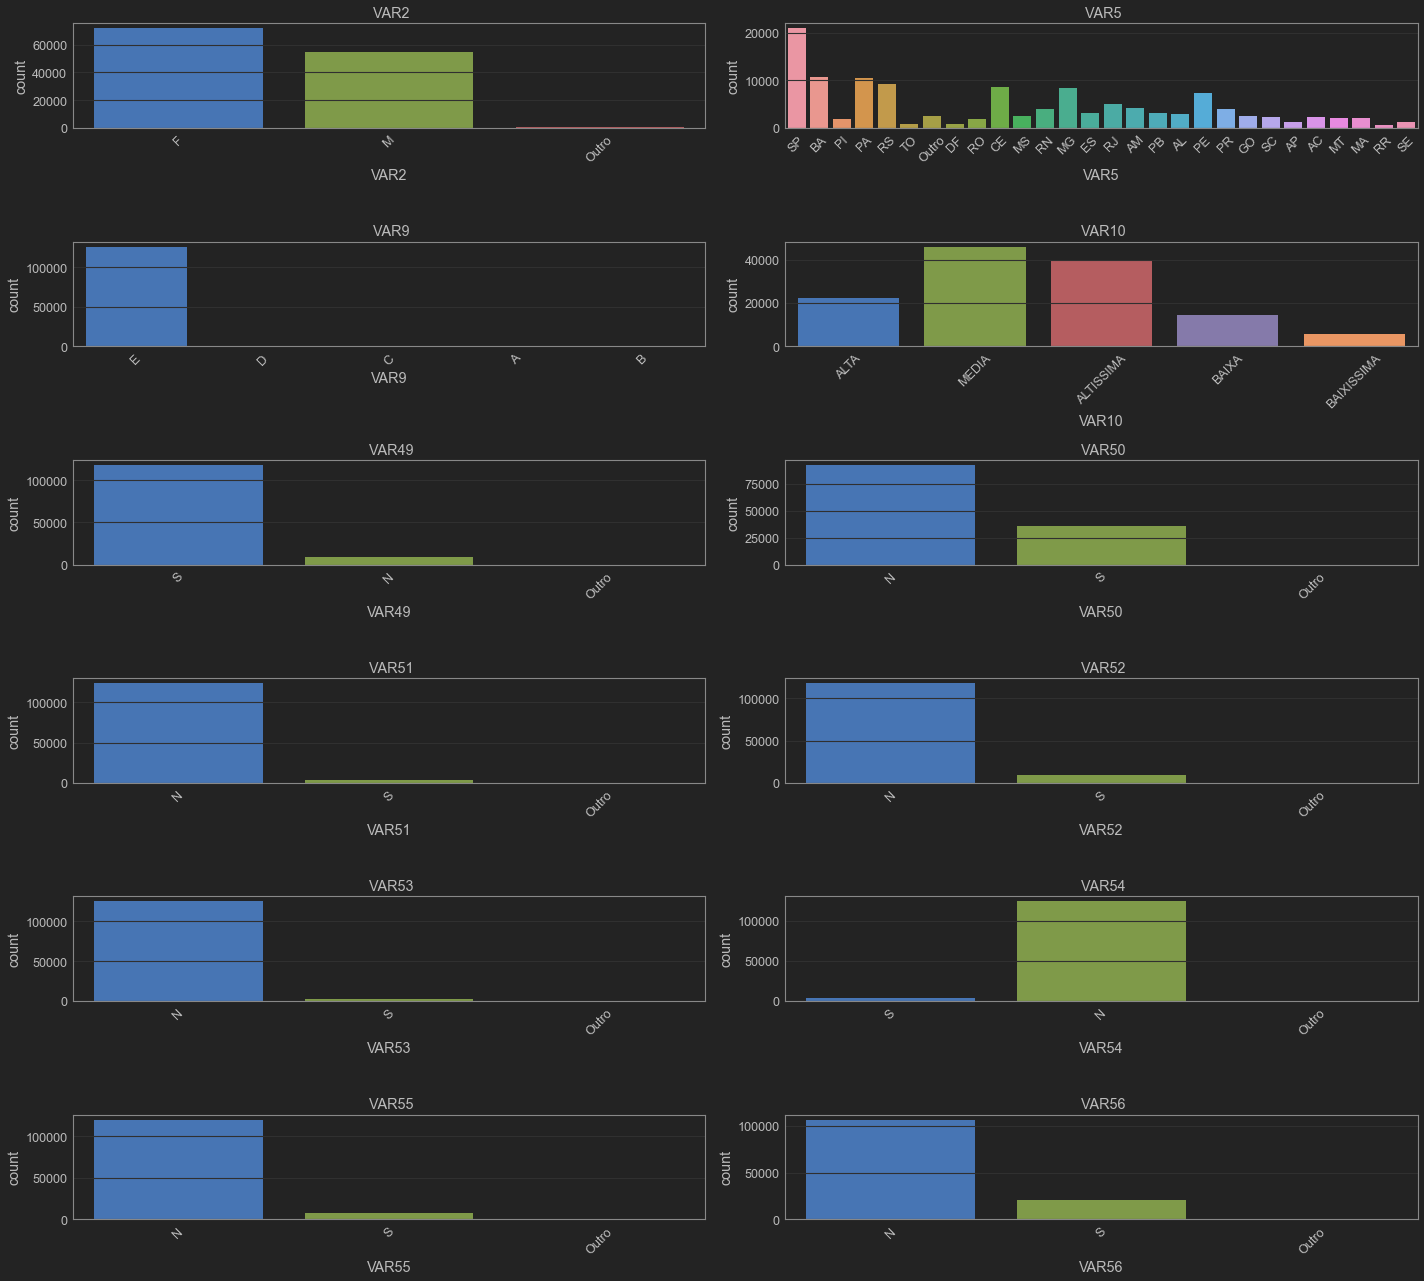

In [74]:
countplot_barplot_features = ['VAR2', 'VAR5', 'VAR9', 'VAR10', 'VAR49', 'VAR50', 'VAR51' , 'VAR52',
                              'VAR53', 'VAR54', 'VAR55', 'VAR56']
num_features = len(countplot_barplot_features)
num_rows = (num_features + 1) // 2  # Arredonda para cima 
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 18))
for i, feature in enumerate(countplot_barplot_features):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    sns.countplot(data=cat_attributes, x=feature, ax=ax)
    ax.set_title(f' {feature}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  
for i in range(num_features, num_rows * num_cols):
    fig.delaxes(axes[i // num_cols, i % num_cols])
plt.tight_layout()
plt.show()

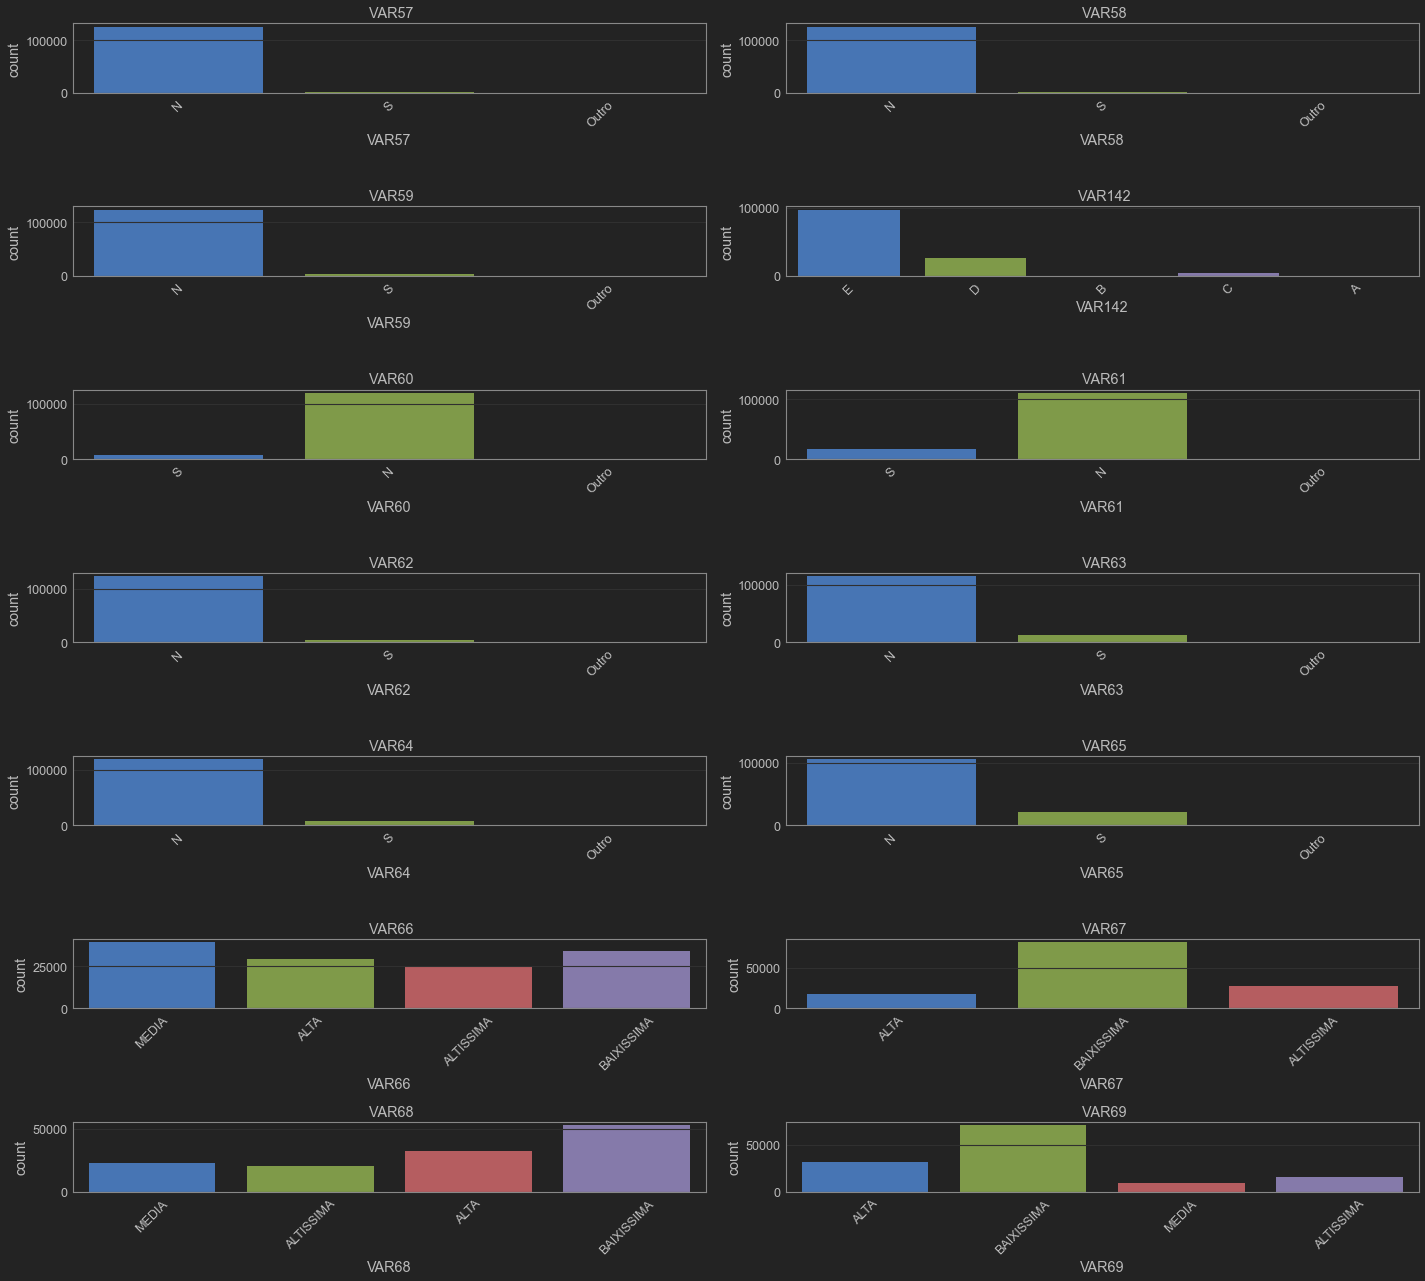

In [75]:

countplot_barplot_features = [ 'VAR57', 'VAR58', 'VAR59','VAR142',
                              'VAR60', 'VAR61', 'VAR62', 'VAR63', 'VAR64', 'VAR65', 'VAR66', 'VAR67'
                             , 'VAR68', 'VAR69']
num_features = len(countplot_barplot_features)
num_rows = (num_features + 1) // 2  # Arredonda para cima 
num_cols = 2  
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 18))
for i, feature in enumerate(countplot_barplot_features):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    sns.countplot(data=cat_attributes, x=feature, ax=ax)
    ax.set_title(f' {feature}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  
for i in range(num_features, num_rows * num_cols):
    fig.delaxes(axes[i // num_cols, i % num_cols])
plt.tight_layout()
plt.show()

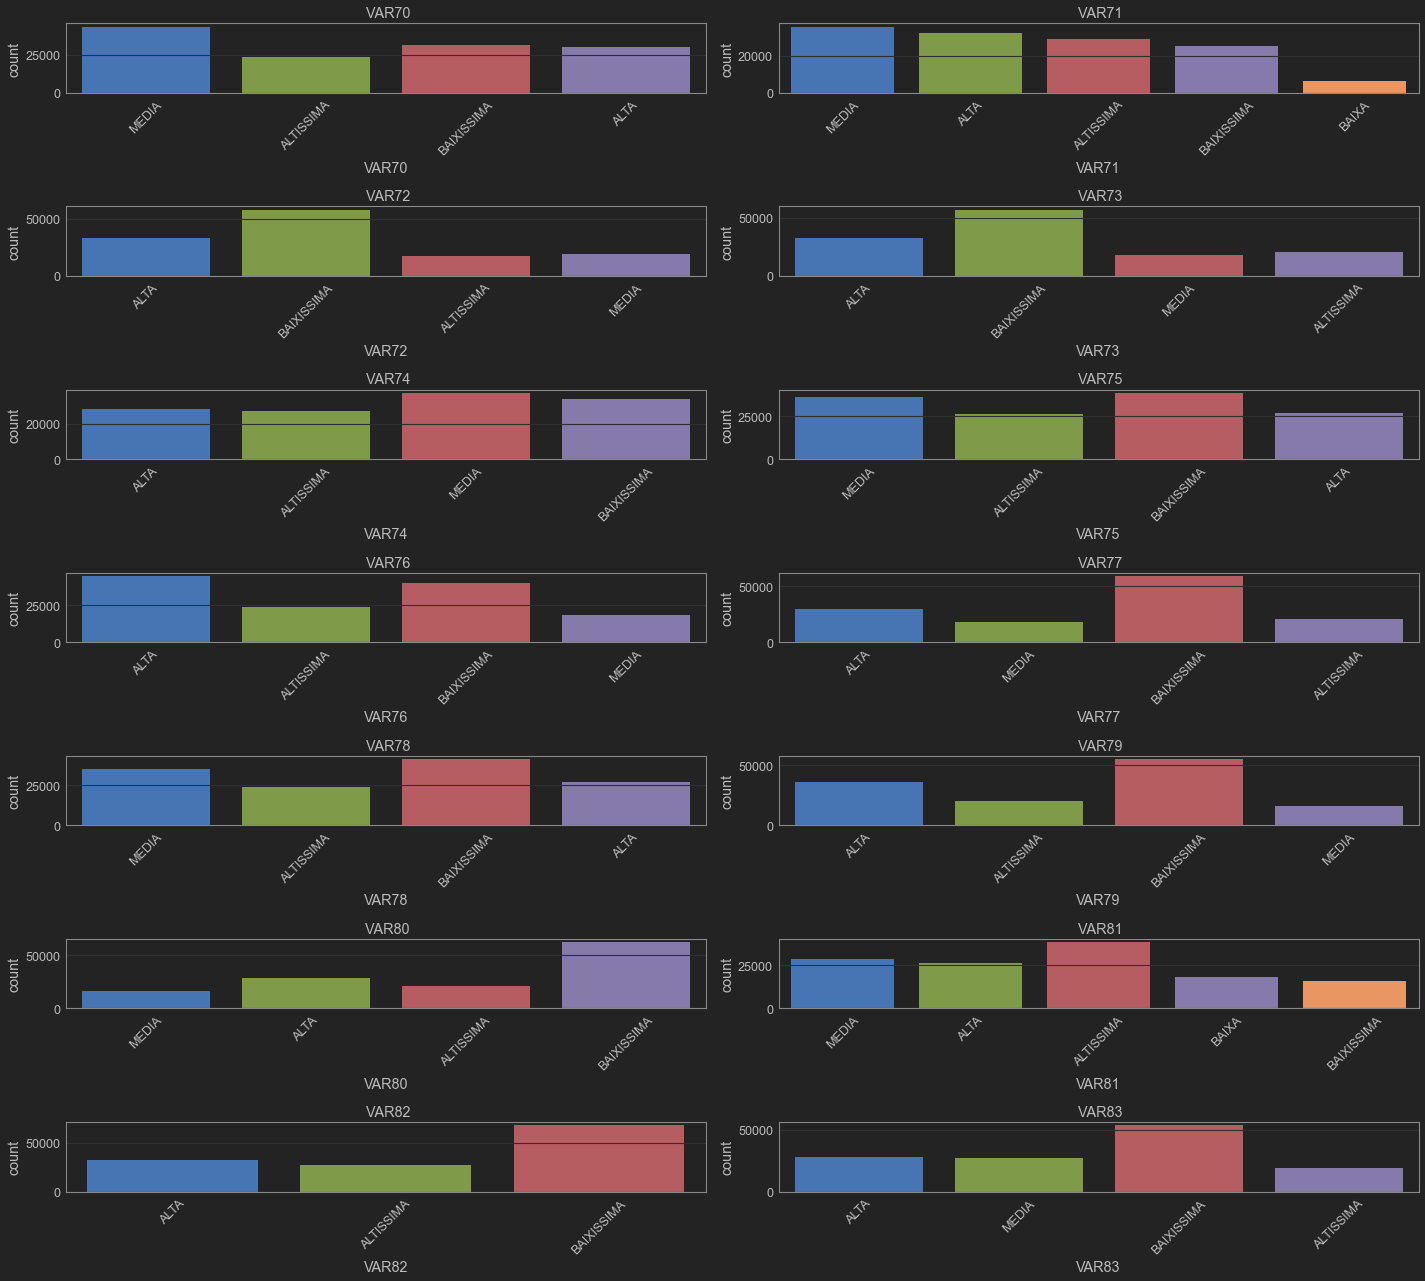

In [76]:
countplot_barplot_features = [ 'VAR70', 'VAR71', 'VAR72','VAR73','VAR74', 'VAR75', 'VAR76', 
                              'VAR77', 'VAR78', 'VAR79', 'VAR80', 'VAR81', 'VAR82', 'VAR83']
num_features = len(countplot_barplot_features)
num_rows = (num_features + 1) // 2  # Arredonda para cima 
num_cols = 2  
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 18))
for i, feature in enumerate(countplot_barplot_features):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]    
    sns.countplot(data=cat_attributes, x=feature, ax=ax)
    ax.set_title(f' {feature}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotação dos rótulos 
for i in range(num_features, num_rows * num_cols):
    fig.delaxes(axes[i // num_cols, i % num_cols])
plt.tight_layout()  
plt.show()

### Análise Bivariada

A continuação relacionamos cada umas das variáveis independentes com a variável TARGET. Isso para detectar gráficamente essas variáveis conseguem discriminar as clases.

In [129]:
df1 = df.copy()

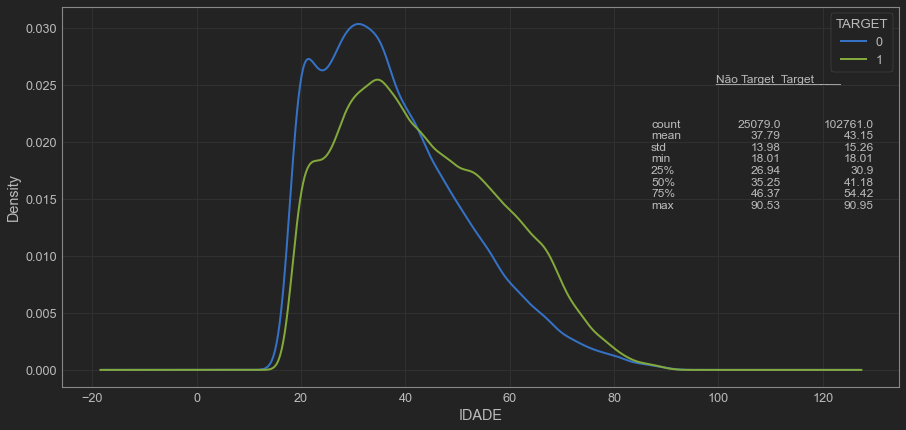

None

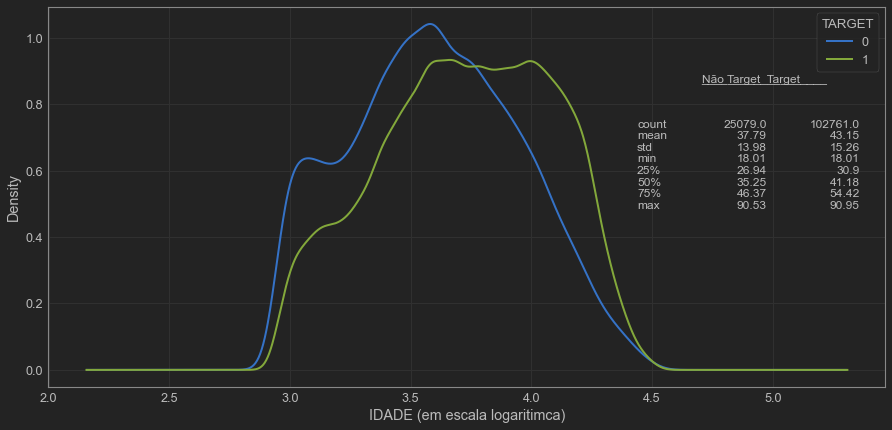

None

In [130]:
display(distribuicao_2(df1, 'IDADE', 1))
display(distribuicao_2(df1, 'IDADE', 0))

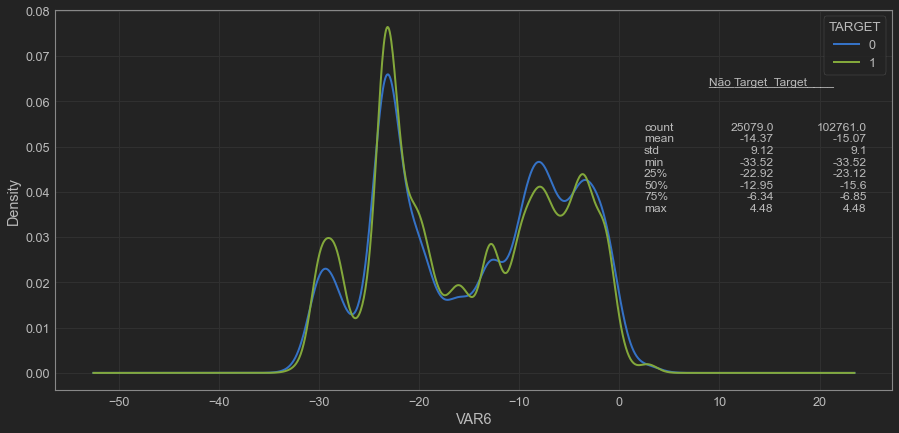

None

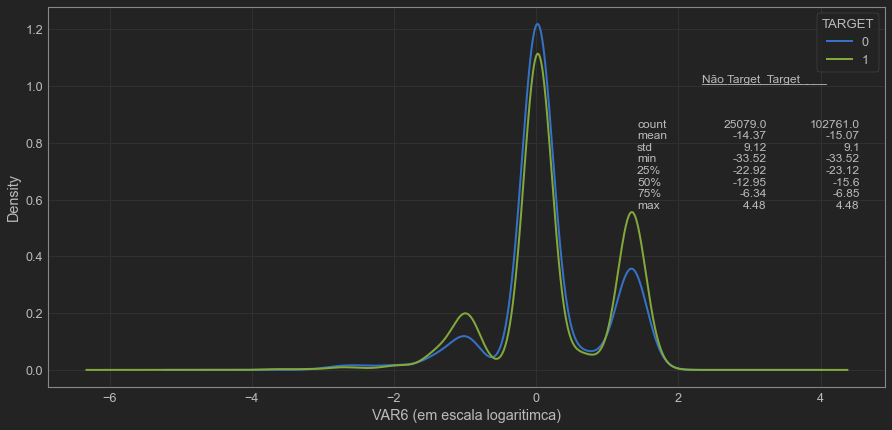

None

In [131]:
display(distribuicao_2(df1, 'VAR6', 1))
display(distribuicao_2(df1, 'VAR6', 0))

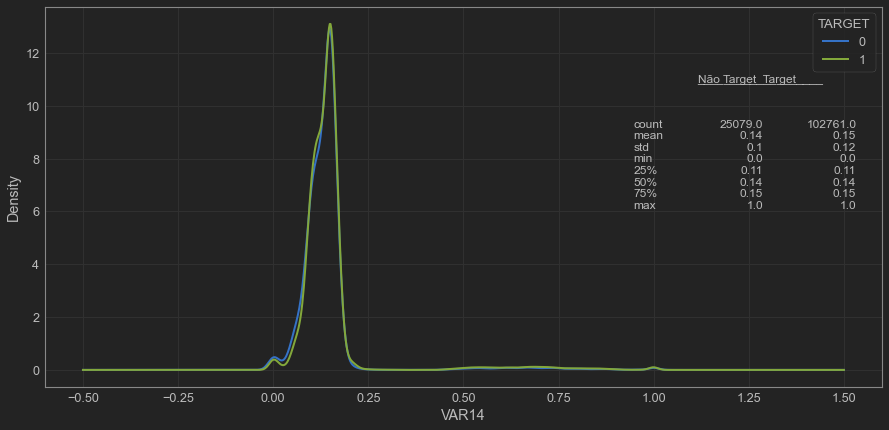

None

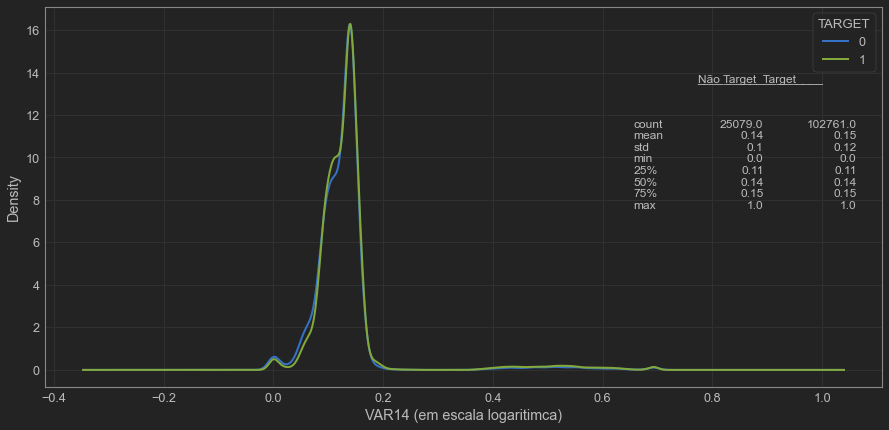

None

In [132]:
display(distribuicao_2(df1, 'VAR14', 1))
display(distribuicao_2(df1, 'VAR14', 0))

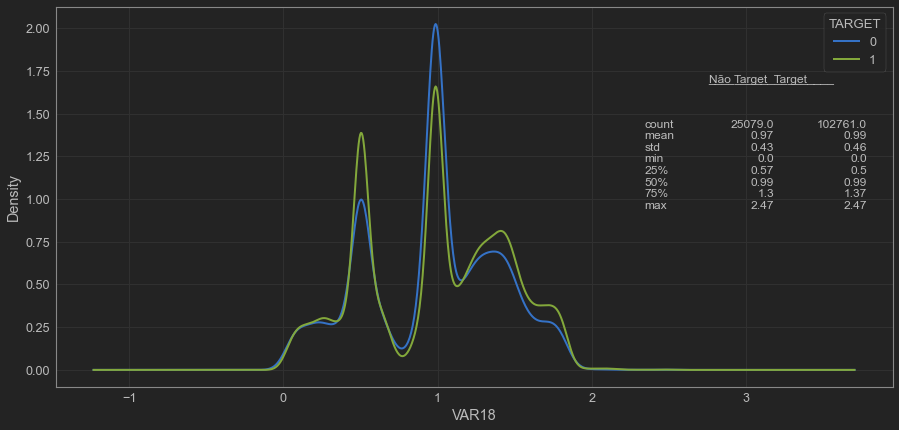

None

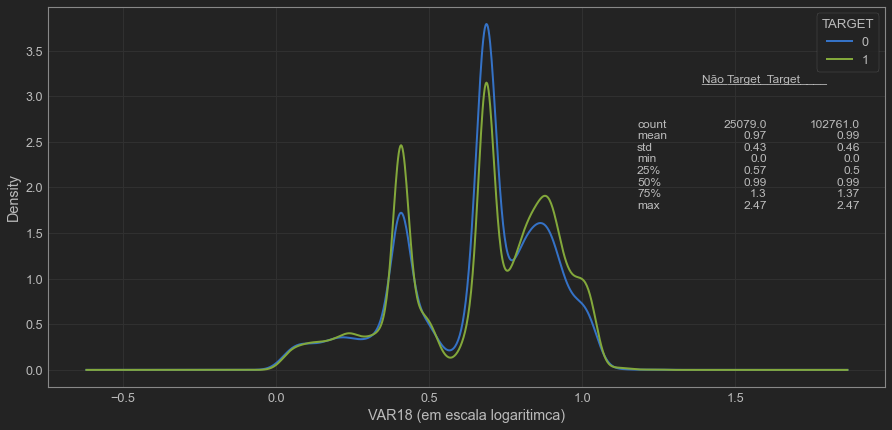

None

In [133]:
display(distribuicao_2(df1, 'VAR18', 1))
display(distribuicao_2(df1, 'VAR18', 0))

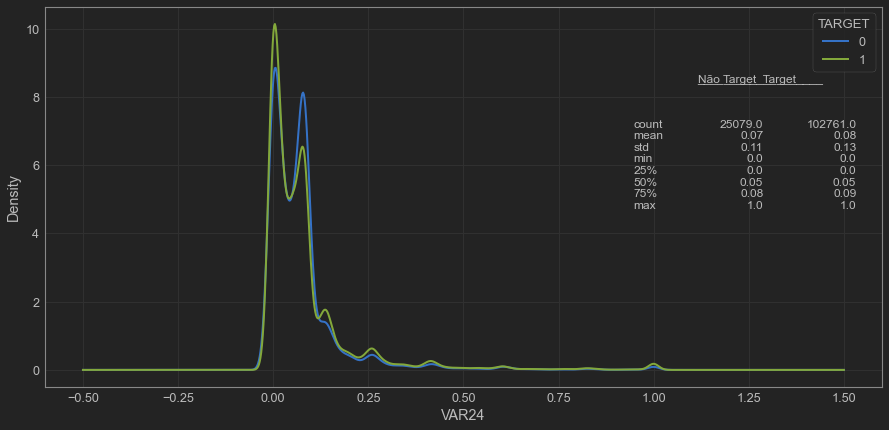

None

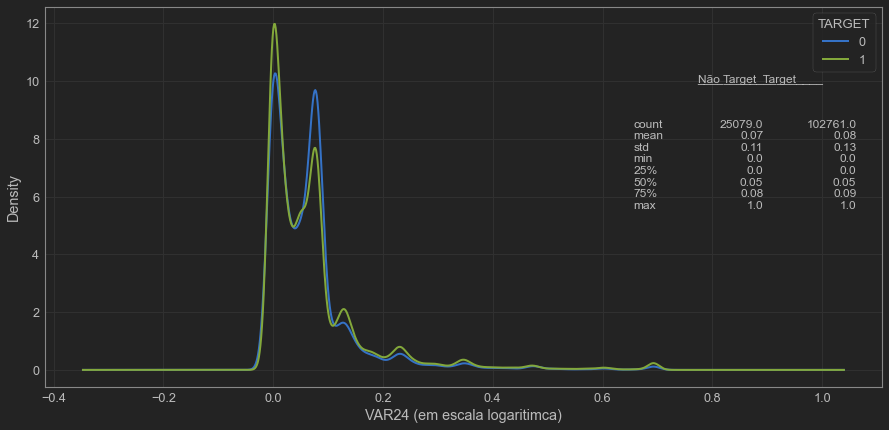

None

In [134]:
display(distribuicao_2(df1, 'VAR24', 1))
display(distribuicao_2(df1, 'VAR24', 0))

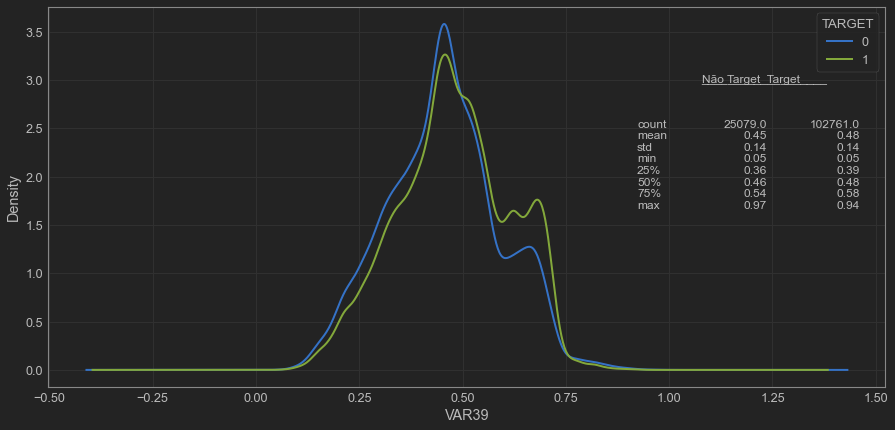

None

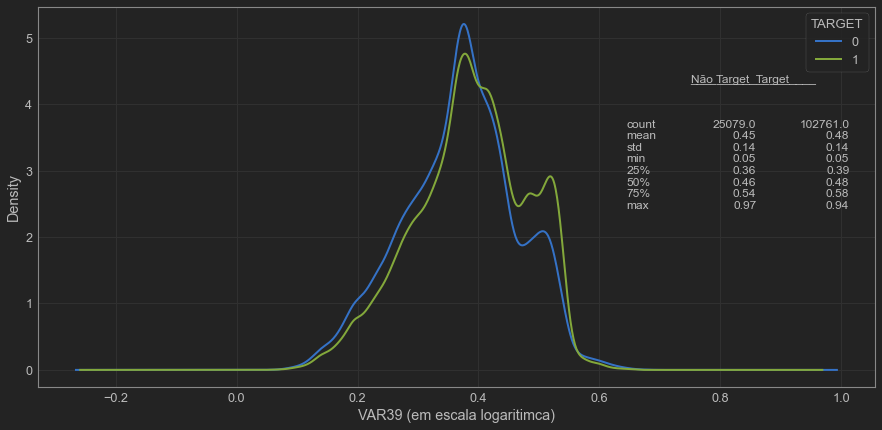

None

In [135]:
display(distribuicao_2(df1, 'VAR39', 1))
display(distribuicao_2(df1, 'VAR39', 0))

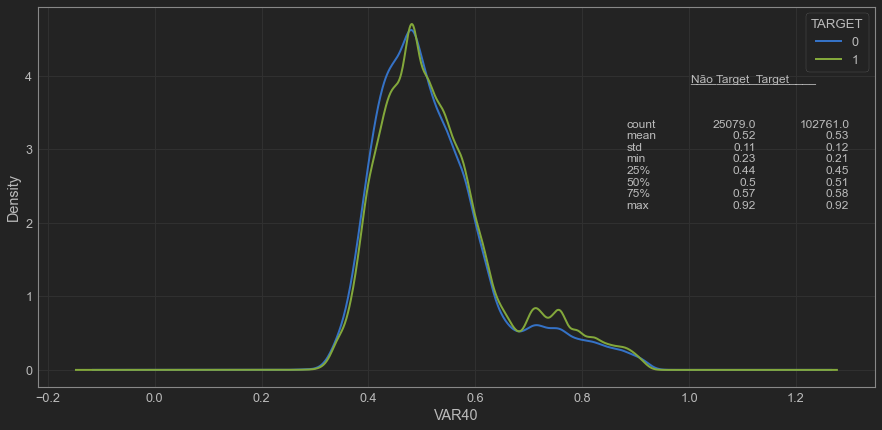

None

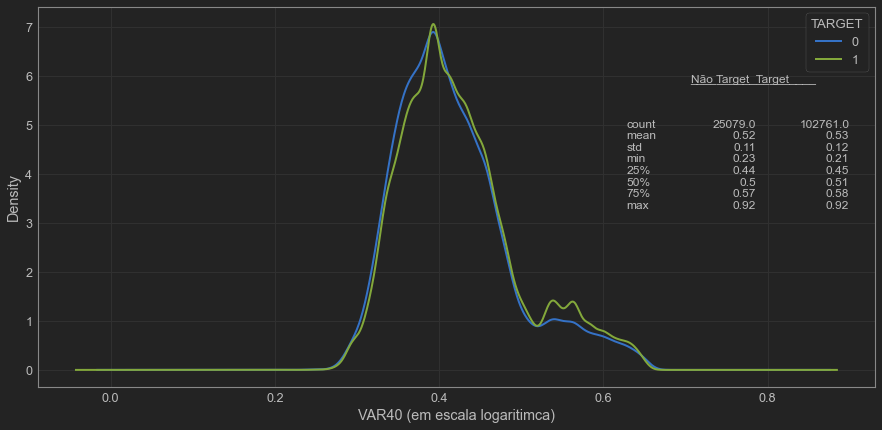

None

In [136]:
display(distribuicao_2(df1, 'VAR40', 1))
display(distribuicao_2(df1, 'VAR40', 0))

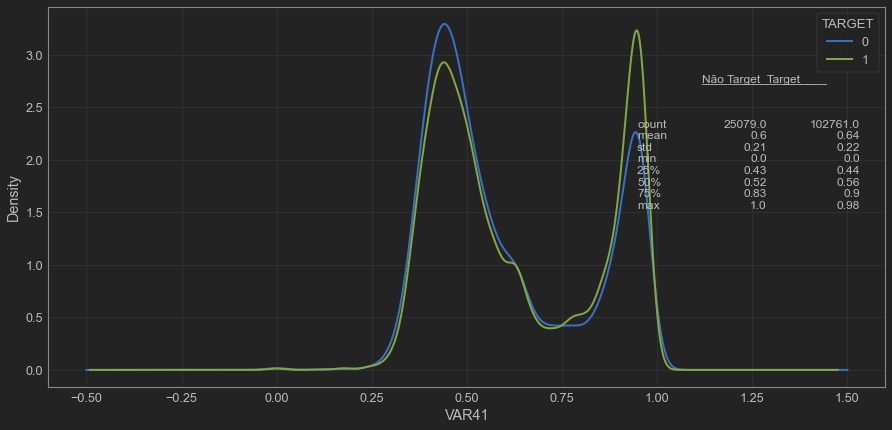

None

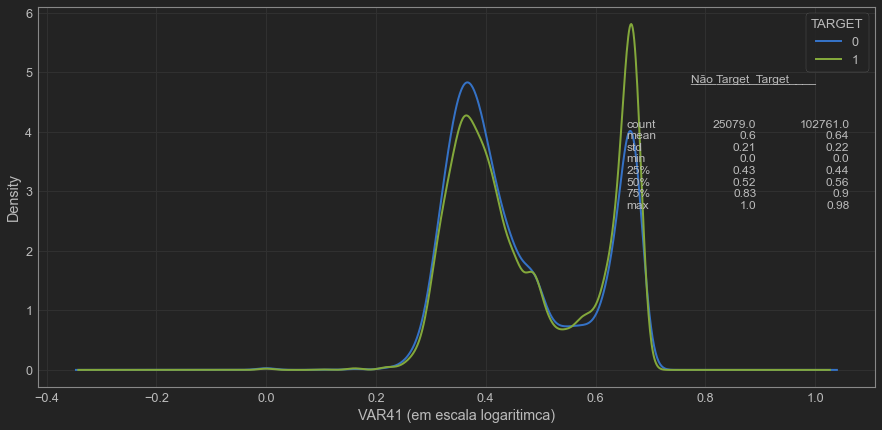

None

In [137]:
display(distribuicao_2(df1, 'VAR41', 1))
display(distribuicao_2(df1, 'VAR41', 0))

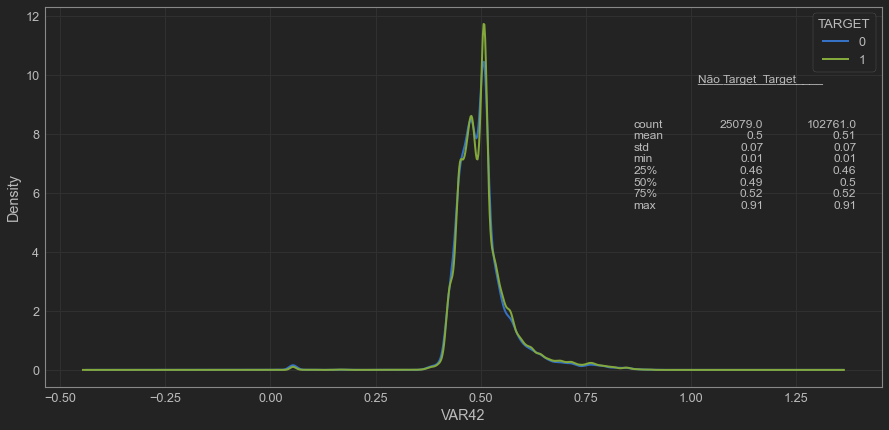

None

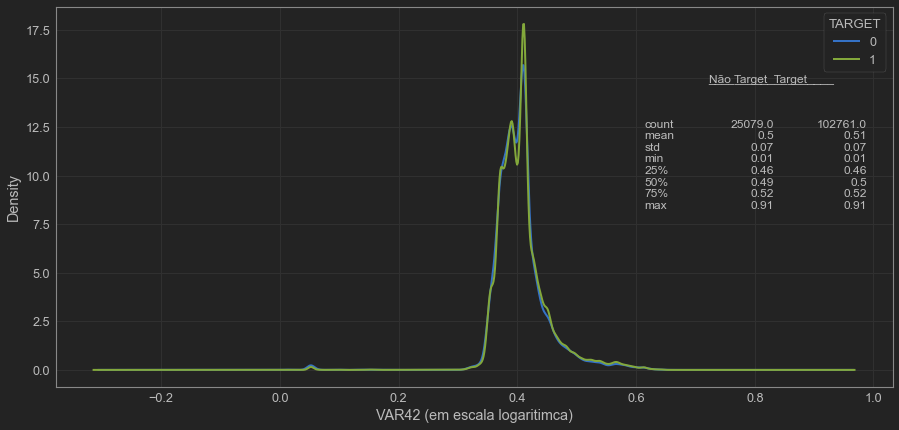

None

In [138]:
display(distribuicao_2(df1, 'VAR42', 1))
display(distribuicao_2(df1, 'VAR42', 0))

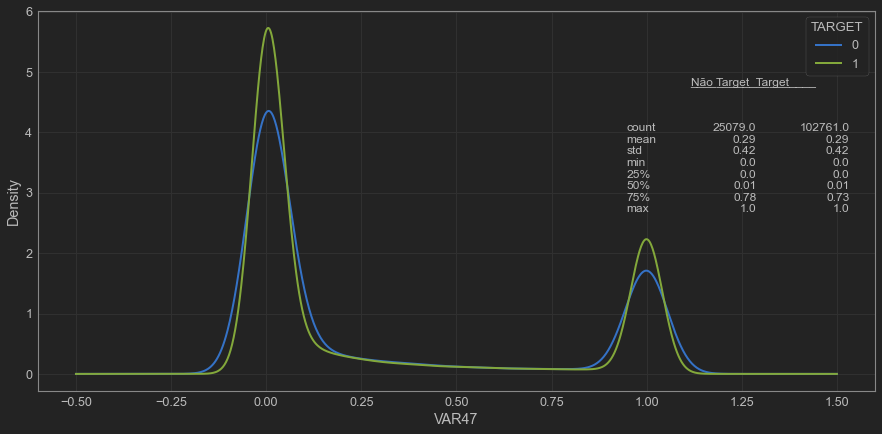

None

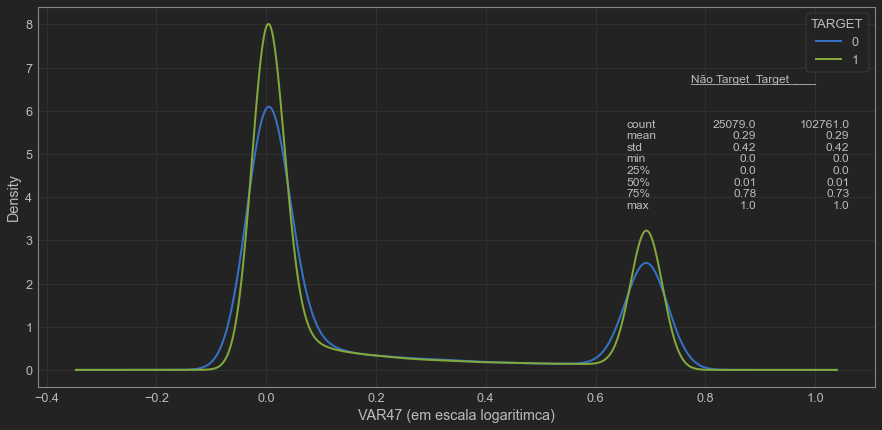

None

In [139]:
display(distribuicao_2(df1, 'VAR47', 1))
display(distribuicao_2(df1, 'VAR47', 0))

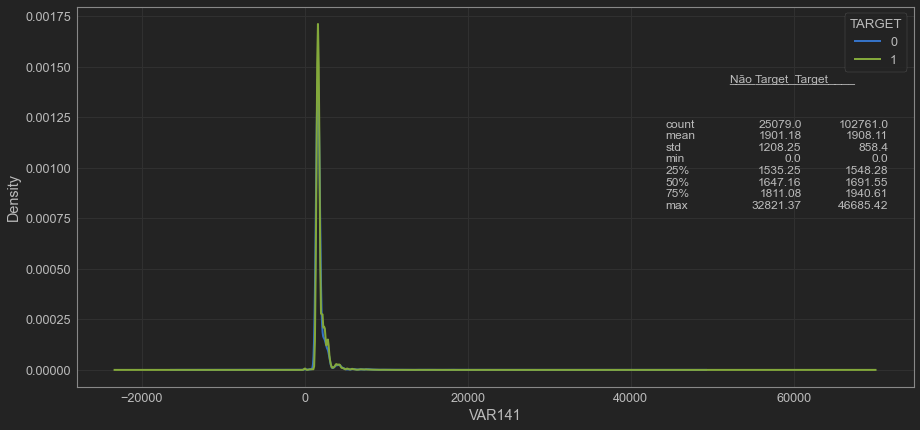

None

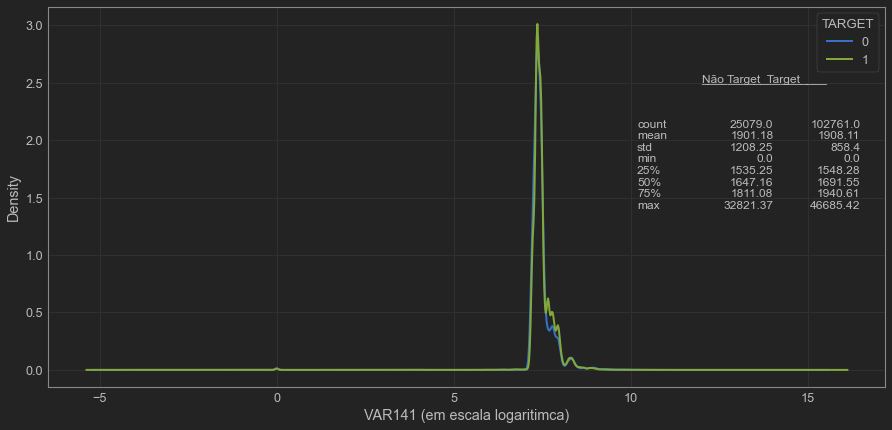

None

In [140]:
display(distribuicao_2(df1, 'VAR141', 1))
display(distribuicao_2(df1, 'VAR141', 0))

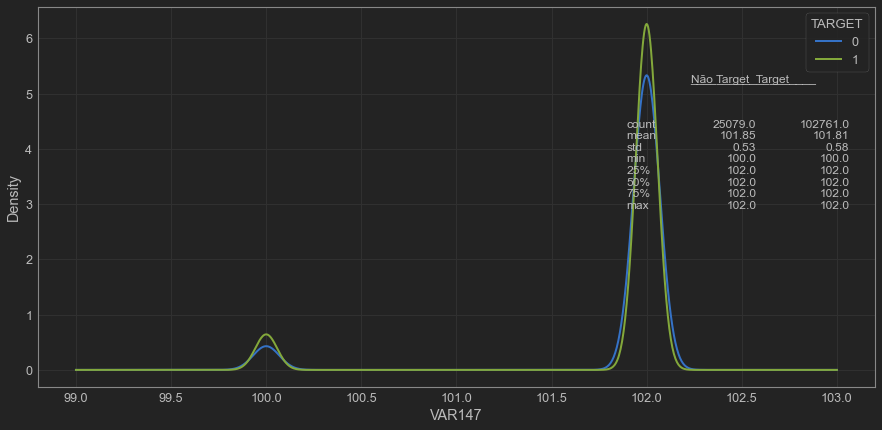

None

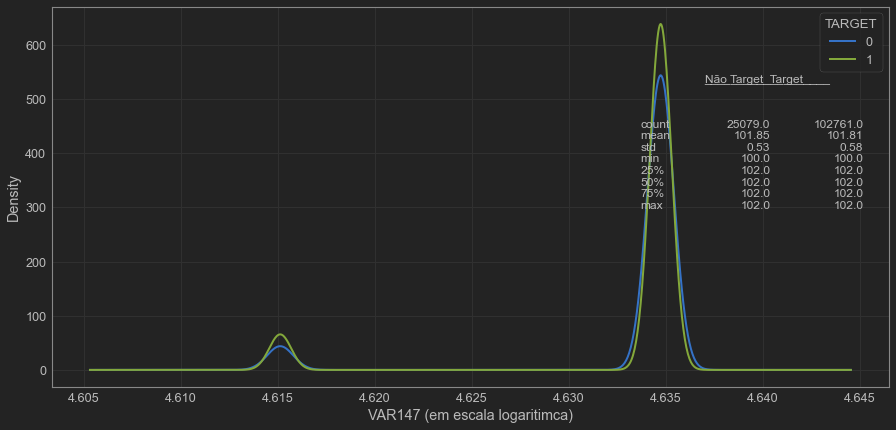

None

In [141]:
display(distribuicao_2(df1, 'VAR147', 1))
display(distribuicao_2(df1, 'VAR147', 0))

Ponto Importante: <br>Acabamos de verificar que as nossas variáveis não están conseguindo discriminar as nossas classes de maneira  significante. As médias normalmente encontranse muito próximas. Desde já sabemos que o problema será muito desafiador. 

### Análise Multivariada

#### Matriz de Correlação

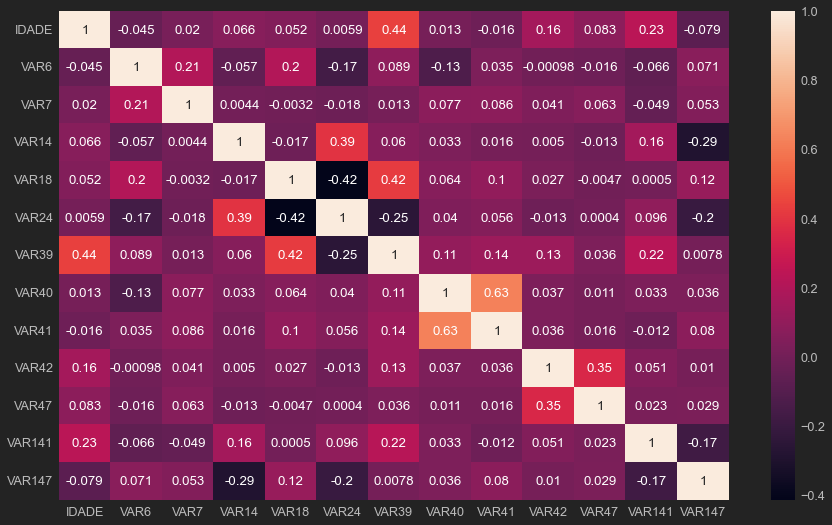

In [142]:
columns_corr= ['IDADE', 'VAR6', 'VAR7', 'VAR14', 'VAR18', 'VAR24', 'VAR39',
       'VAR40', 'VAR41', 'VAR42', 'VAR47', 'VAR141', 'VAR147']
df_corr = df[columns_corr].copy() 

fig = plt.figure(figsize =(15, 9))
correlation = df_corr.corr(method='pearson')
sns.heatmap(correlation,annot=True);

Nota: <br>Observamos que as nossas variáveis numéricas não tem fortes correlações ao ponto que possam vir a deixarnos em risco de Multicolinearidade. Mas considerando a análise bivariada, onde as variáveis não conseguem discriminar as classes, conseguimos ver que na análise multivariada que algumas varíaveis combinadas conseguem aumentar a relevancia delas. 

#### Análise de Fatores

Tentando explorar novas formas de relacionamento entre as features, peguei um bloco de features que tem os mesmo tipos de dados e na mesma nomenclatura, para someter ele a uma Análise de Fatores.
Para executar uma Análise Fatorial de um subconjunto do meu dataset, farei o seguinte:
* Criarei um dataframe auxiliar com as variaveis.<br>
* Aplicarei LabelEncoder nas variáveis para conseguir trabalhar com FactorAnalyzis.
* Aplicarei FactorAnalyzis.
* Examinarei as cargas do fator.

In [143]:
df_auxiliar =  df[['VAR49', 'VAR50', 'VAR51', 'VAR52', 'VAR53', 'VAR54', 'VAR55', 'VAR56', 'VAR57', 'VAR58', 'VAR59', 'VAR60', 'VAR61', 'VAR62', 
           'VAR63', 'VAR64', 'VAR65']]

In [144]:
colunas_selecionadas = df[['VAR49', 'VAR50', 'VAR51', 'VAR52', 'VAR53', 'VAR54', 'VAR55', 'VAR56', 
                           'VAR57', 'VAR58', 'VAR59', 'VAR60', 'VAR61', 'VAR62', 'VAR63', 'VAR64', 'VAR65']]

In [145]:
le = LabelEncoder()
# Itere sobre as colunas selecionadas e aplique o LabelEncoder
for colun in colunas_selecionadas.columns:
    df_auxiliar[colun] = le.fit_transform(df_auxiliar[colun])

In [146]:
colunas_selecionadas = df_auxiliar[['VAR49', 'VAR50', 'VAR51', 'VAR52', 'VAR53', 'VAR54', 'VAR55', 'VAR56', 
                           'VAR57', 'VAR58', 'VAR59', 'VAR60', 'VAR61', 'VAR62', 'VAR63', 'VAR64', 'VAR65']]

In [147]:
from sklearn.decomposition import FactorAnalysis
model = FactorAnalysis(n_components=1)  # Substitua 3 pelo número desejado de fatores
model.fit_transform(colunas_selecionadas) # Ajuste o modelo aos seus dados

array([[-0.37247197],
       [-0.57682415],
       [-0.49245108],
       ...,
       [ 0.43013213],
       [ 1.52405667],
       [-0.02522729]])

In [148]:
cargas_fatoriais = model.components_  
print("Cargas Fatoriais:")  
print(cargas_fatoriais) 

Cargas Fatoriais:
[[ 0.10278803  0.75755609  0.1010771   0.09653516  0.05555259  0.01085912
   0.15767043  0.14636041 -0.00581047  0.03799196  0.06323212  0.04993239
   0.15520107  0.0560009   0.22249013  0.16248342  0.62857604]]


In [149]:
variância_explicada = model.noise_variance_
print("Variância Explicada pelo Fator:")
print(variância_explicada)

Variância Explicada pelo Fator:
[0.2634302  0.22867979 0.1093402  0.26963997 0.07832339 0.11922548
 0.2064842  0.52728247 0.0681446  0.045872   0.13760883 0.22081228
 0.43709069 0.12691948 0.31386135 0.20528666 0.17466024]


Ponto Importante:<br> Se a carga fatorial de uma variável for significativamente alta, isso sugere uma forte associação entre a variável e o fator, o que revela que a variável pode ser de certa importancia para o modelo. Neste caso, observamos duas variáveis ultrapassando os 50% de significancia.

### Hipoteses Levantadas

Levantamos algumas hipóteses aleatoria:<br><br>
H1. Os jóvens são menos Bom Pagadores em comparação das outras faixas etáreas.<br>
H2. São Paulo é o Estado com menor inadimplencia em relação dos outros estados.<br>
H3. O sexo masculino é mais inadimplente do que o sexo femenino.<br>
H4. Os Idosos são a população de maior risco em relação a inadimplencia.<br><br>
Agora responderemos rápidamente a esses questionamentos.

##### H1.  Os jóvens são menos Bom Pagadores em comparação das outras faixas etáreas.

VERDADE. As duas faixas mais jovens são as que MENOS proporção de BOM PAGADOR tem. 

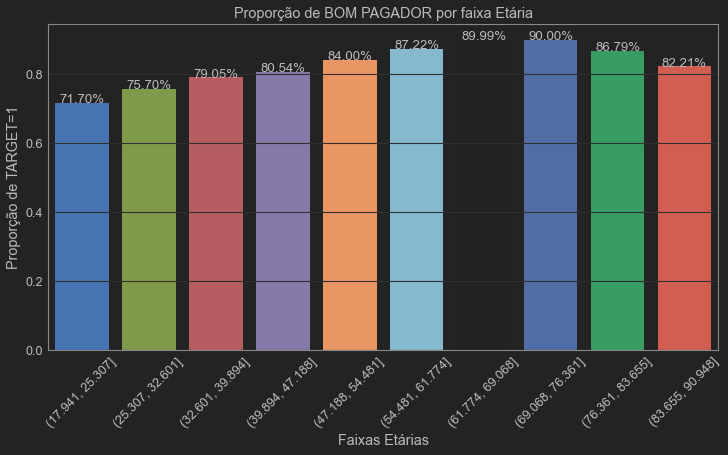

In [172]:
df4 = df.copy()

plt.figure(figsize=(12, 6))  # Define o tamanho da figura
df4['IDADE_bins'] = pd.cut(df4['IDADE'], bins=10)  # Defina o número de bins aqui
data_to_plot = df4.groupby('IDADE_bins')['TARGET'].apply(lambda x: (x == 1).sum() / len(x)).reset_index()
ax = sns.barplot(data=data_to_plot, x='IDADE_bins', y='TARGET')
plt.xlabel('Faixas Etárias')
plt.ylabel('Proporção de TARGET=1')
plt.title('Proporção de BOM PAGADOR por faixa Etária')
plt.xticks(rotation=45)  # Rotação dos rótulos do eixo x, se necessário
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2%}', (p.get_x() + p.get_width() / 2., height), ha='center', va='baseline')
plt.show()

#### H2. São Paulo é o Estado com menor inadimplencia em relação dos outros estados.

FALSO. São Paulo se mostrou o Estado com maior inadimplencia.

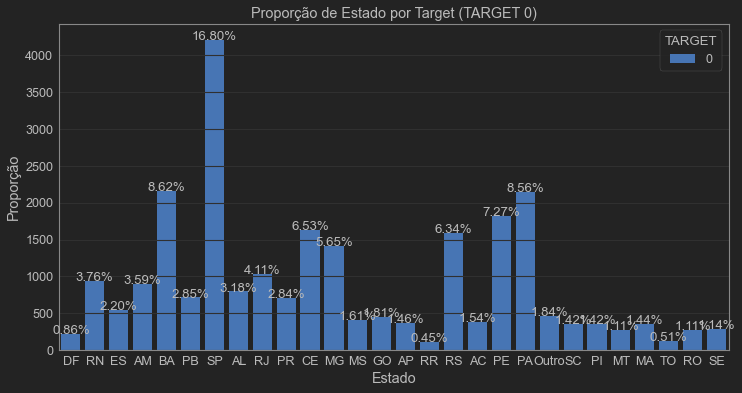

In [173]:
plt.figure(figsize=(12, 6)) 
df4_target_0 = df4[df4['TARGET'] == 0]
ax = sns.countplot(data=df4_target_0, x='VAR5', hue='TARGET')
plt.xlabel('Estado')
plt.ylabel('Proporção')
plt.title('Proporção de Estado por Target (TARGET 0)')
total_counts = len(df4_target_0)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height/total_counts:.2%}', (p.get_x() + p.get_width() / 2., height), ha='center', va='baseline')
plt.legend(title='TARGET', labels=['0'])  # Adicione uma legenda para o valor de TARGET 0
plt.show()

#### H3. O sexo masculino é mais inadimplente do que o sexo femenino.

Falso. O sexo Masculino é menos inadimplente do que o sexo Femenino.

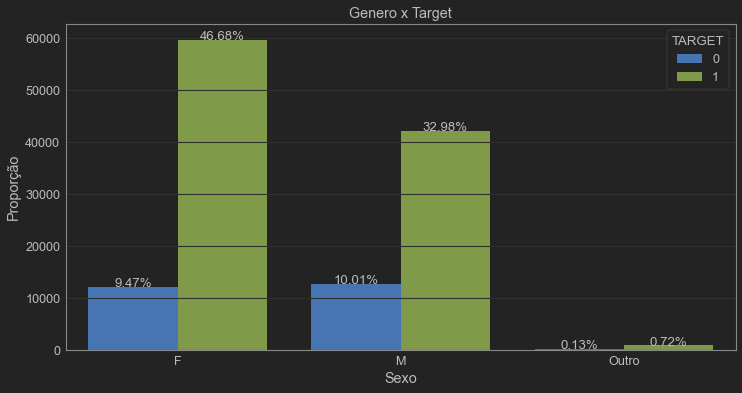

In [174]:
plt.figure(figsize=(12, 6))  # Define o tamanho da figura
ax = sns.countplot(data=df4, x='VAR2', hue='TARGET')
plt.xlabel('Sexo')
plt.ylabel('Proporção')
plt.title('Genero x Target')
total_counts = len(data)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height/total_counts:.2%}', (p.get_x() + p.get_width() / 2., height), ha='center', va='baseline')
plt.legend(title='TARGET', labels=['0', '1'])  # Adicione uma legenda para os valores de TARGET
plt.show()

#### H4. Os Idosos são a população de maior risco em relação a inadimplencia.

FALSO. As Faixa de Idades mais inadimplente são os mais jóvens.

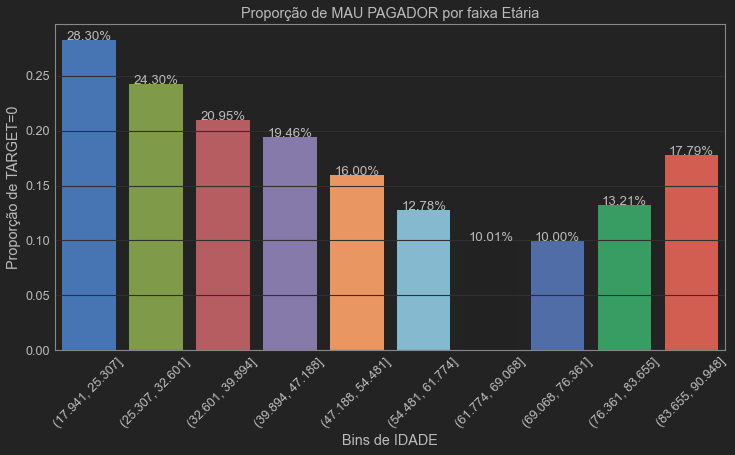

In [175]:
plt.figure(figsize=(12, 6))  # Define o tamanho da figura
df4['IDADEx_bins'] = pd.cut(df4['IDADE'], bins=10)  # Defina o número de bins aqui
data_to_plot = df4.groupby('IDADEx_bins')['TARGET'].apply(lambda x: (x == 0).sum() / len(x)).reset_index()
ax = sns.barplot(data=data_to_plot, x='IDADEx_bins', y='TARGET')
plt.xlabel('Bins de IDADE')
plt.ylabel('Proporção de TARGET=0')
plt.title('Proporção de MAU PAGADOR por faixa Etária')
plt.xticks(rotation=45)  # Rotação dos rótulos do eixo x, se necessário
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2%}', (p.get_x() + p.get_width() / 2., height), ha='center', va='baseline')
plt.show()

## Conclusões

Principais conclusões:<br>
1. As medias de idades entre as classes conseguem ser moderadamente discriminadoras, conseguindo separar as distribuições das classes. Isso resulta um bom indicador na hora de considerar as variáveis e sua futura rlevancia na hora de inserir como variável proditora.
2. As variáveis numéricas apresentaram baixos indices de correlação, só algumas delas conseguiram chegar em 22% de correlação. Isso, a princípio, descarta possibilidades de Multicolinearidade (situação de que debemos evitar quando aparecer nos nossos dados, porque pode nos levar a incorrer em risco de overfitting. 
3. A maioria das variáveis numéricas tem se mostrado como distribuição normal, o que resulta alentador, já que cumpre com a premissa dos modelos de machine learning para facilitar a generalização do comportamento dos dados. Existem alguns bem distantes de uma normal. Poderia ser uma opção aplicar Transformação de logaritmica ou inclusive aplicar Z-score, para trazer esses dados próximos de um comportamento normal.
4. Identificamos outliers grosseiros nos dados, sendo uma boa quantidade distantes das medidas centrais. Debemos tratar eles de maneira independente. 
5. A Análise Fatorial tem mostrado que juntar essas variáveis de características parecidas resulta num moderado impacto de associação entre essas variáveis, chegando a revalorizar algumas delas. Seria exelente considerar explorar essa possibilidade. 
6. A análise exploratória mostrou a complexidade dos dados, que na sua maioria não conseguem discriminar uma classe da outra, isso já mostra que a modelagem será complexa. Mas ao mesmo tempo mostrou que podemos trabalhar em algumas variáveis que podem chegar a ser a nossa bússola para abordar a modelagem - caso IDADE, VAR7, VAR39, VAR41 - do desafío.